# AdventureGame Evaluation
This notebook produces tables and plots to analyse AdventureGame results. All plots and tables appearing in the AdventureGame paper are created using the contained code.

In [1]:
import sys
# sys.path.append('..')

from pathlib import Path

import json
import os

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.colors import ListedColormap
from matplotlib.patches import Polygon
from numpy.ma.extras import average

import evaluation.evalutils as utils
from evaluation.makingtables import build_dispersion_table
import evaluation.clemmetrics as clemmetrics

Choose path for the .csv with the raw scores. This is created after running ```bencheval.py```.

In [2]:
RAW_PATH = Path('results/raw.csv')
raw_df = pd.read_csv(RAW_PATH, index_col=0)

Full results dataframe:

In [3]:
raw_df

,game,model,experiment,episode,metric,value
0,adventuregame,claude-3-5-sonnet-20241022-t0.0--claude-3-5-so...,0_home_deliver_three_basic_easy,episode_0,Violated Request Count,0.0
1,adventuregame,claude-3-5-sonnet-20241022-t0.0--claude-3-5-so...,0_home_deliver_three_basic_easy,episode_0,Parsed Request Count,10.0
2,adventuregame,claude-3-5-sonnet-20241022-t0.0--claude-3-5-so...,0_home_deliver_three_basic_easy,episode_0,Request Count,10.0
3,adventuregame,claude-3-5-sonnet-20241022-t0.0--claude-3-5-so...,0_home_deliver_three_basic_easy,episode_0,Request Success Ratio,1.0
4,adventuregame,claude-3-5-sonnet-20241022-t0.0--claude-3-5-so...,0_home_deliver_three_basic_easy,episode_0,hallucination_count,0.0
...,...,...,...,...,...,...
99707,adventuregame,Sky-T1-32B-Preview-t0.0--Sky-T1-32B-Preview-t0.0,7_home_deliver_three_planning_hard_invlimittwo,episode_5,Played,1.0
99708,adventuregame,Sky-T1-32B-Preview-t0.0--Sky-T1-32B-Preview-t0.0,7_home_deliver_three_planning_hard_invlimittwo,episode_6,Played,1.0
99709,adventuregame,Sky-T1-32B-Preview-t0.0--Sky-T1-32B-Preview-t0.0,7_home_deliver_three_planning_hard_invlimittwo,episode_7,Played,1.0
99710,adventuregame,Sky-T1-32B-Preview-t0.0--Sky-T1-32B-Preview-t0.0,7_home_deliver_three_planning_hard_invlimittwo,episode_8,Played,1.0


Dictionaries for converting full model, experiment and score/metric names to compact names:

In [4]:
model_name_dict = {
    # 'gemma-2-9b-it-GGUF-q5-t0.0--gemma-2-9b-it-GGUF-q5-t0.0': "gemma-2-9b-it-q5",
    # 'gemma-7b-it-Groq-t0.0--gemma-7b-it-Groq-t0.0': "gemma-7b-it",
    # 'gemma2-9b-it-Groq-t0.0--gemma2-9b-it-Groq-t0.0': "gemma2-9b-it",
    # 'Llama-3-70B-Instruct-Groq-t0.0--Llama-3-70B-Instruct-Groq-t0.0': "Llama-3-70B-Instruct",
    # 'Llama-3-8B-Instruct-Groq-t0.0--Llama-3-8B-Instruct-Groq-t0.0': "Llama-3-8B-Instruct",
    # 'llama-3.1-70b-versatile-Groq-t0.0--llama-3.1-70b-versatile-Groq-t0.0': "Llama-3.1-70b-Instruct",
    # 'llama-3.1-8b-instant-Groq-t0.0--llama-3.1-8b-instant-Groq-t0.0': "Llama-3.1-8b-Instruct",
    # 'LLaMA2-13B-Tiefighter-t0.0--LLaMA2-13B-Tiefighter-t0.0': "LLaMA2-13B-Tiefighter",
    # 'Meta-Llama-3.1-405B-Instruct-Turbo-TogetherAI-t0.0--Meta-Llama-3.1-405B-Instruct-Turbo-TogetherAI-t0.0': "Llama-3.1-405B-Instruct",
    # 'Mistral-Large-Instruct-2407-t0.0--Mistral-Large-Instruct-2407-t0.0': "Mistral-Large-Instruct-2407",
    # 'openchat_3.5-GGUF-q5-t0.0--openchat_3.5-GGUF-q5-t0.0': "openchat3.5-GGUF-q5",
    'openchat_3.5-GGUF-q8-t0.0--openchat_3.5-GGUF-q8-t0.0': 'openchat3.5-GGUF-q8',
    'openchat_3.5-t0.0--openchat_3.5-t0.0': "openchat3.5",
    # 'Qwen1.5-72B-Chat-t0.0--Qwen1.5-72B-Chat-t0.0': "Qwen1.5-72B-Chat",
    'Qwen2-72B-Instruct-t0.0--Qwen2-72B-Instruct-t0.0': "Qwen2-72B-Instruct",
    'Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0': 'Llama-3.1-8B-Instruct',
    'Meta-Llama-3-8B-Instruct-t0.0--Meta-Llama-3-8B-Instruct-t0.0': 'Llama-3-8B-Instruct',
    'Qwen2.5-7B-Instruct-t0.0--Qwen2.5-7B-Instruct-t0.0': 'Qwen2.5-7B-Instruct',
    'Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0': 'Qwen2.5-Coder-32B-Instruct',
    'Qwen2.5-Coder-7B-Instruct-t0.0--Qwen2.5-Coder-7B-Instruct-t0.0': 'Qwen2.5-Coder-7B-Instruct',
    'Qwen2.5-72B-Instruct-t0.0--Qwen2.5-72B-Instruct-t0.0': 'Qwen2.5-72B-Instruct',
    'Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0': 'Llama-3.3-70B-Instruct',
    'Meta-Llama-3.1-70B-Instruct-t0.0--Meta-Llama-3.1-70B-Instruct-t0.0': 'Llama-3.1-70B-Instruct',
    'Sky-T1-32B-Preview-t0.0--Sky-T1-32B-Preview-t0.0': 'Sky-T1-32B-Preview',
    'llama-3.1-405b-t0.0--llama-3.1-405b-t0.0': 'Llama-3.1-405b',
    'gpt-4o-2024-08-06-t0.0--gpt-4o-2024-08-06-t0.0': 'GPT-4o-2024-08-06',
    'claude-3-5-sonnet-20241022-t0.0--claude-3-5-sonnet-20241022-t0.0': 'Claude-3.5-Sonnet-20241022',
    'qwen-max-t0.0--qwen-max-t0.0': 'Qwen-max',
    'gemini-2.0-flash-exp-t0.0--gemini-2.0-flash-exp-t0.0': 'Gemini-2.0-flash-exp',
    'deepseek-v3-t0.0--deepseek-v3-t0.0': 'DeepSeek-V3',
    'o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0': 'o3-mini-2025-01-31'
}

top_models = [
    'o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0',
    'claude-3-5-sonnet-20241022-t0.0--claude-3-5-sonnet-20241022-t0.0',
    'gpt-4o-2024-08-06-t0.0--gpt-4o-2024-08-06-t0.0',
    'Meta-Llama-3.1-70B-Instruct-t0.0--Meta-Llama-3.1-70B-Instruct-t0.0',
    'Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0'
    ]

experiment_short_name_dict = {
    '0_home_deliver_three_basic_easy': "basic-easy",
    '1_home_deliver_three_planning_easy': "planning-easy",
    '2_home_deliver_three_basic_easy_invlimittwo': "basic-easy-invlimit",
    '3_home_deliver_three_planning_easy_invlimittwo': "planning-easy-invlimit",
    '4_home_deliver_three_basic_hard': "basic-hard",
    '5_home_deliver_three_planning_hard': "planning-hard",
    '6_home_deliver_three_basic_hard_invlimittwo': "basic-hard-invlimit",
    '7_home_deliver_three_planning_hard_invlimittwo': "planning-hard-invlimit"
}

metric_name_dict = {
    'taking_from_inventory': "taking from inventory",
    'other_room_argument': "interacting with other room",
    'not_room_type': "going to non-existent room",
    'going_to_current_room': "going to current room",
    'no_exit_to': "going to non-adjacent room",
    'multiple_exits_to': "ambiguous traversal",
    'entity_already_inventory': "entity already in inventory",
    'thing_arg1_room': "first entity is room",
    'entity_not_accessible': "entity not accessible",
    'multiple_entity_ambiguity': "ambiguous entity",
    'thing_arg2_room': "second entity is room",
    'pre_state_mismatch': "main condition not fact",
    'action_parsing_fail': "parsing failure",
    'action_resolution_fail': "resolution failure",
    'lark_exception': "out of grammar",
    'malformed_command': "malformed command",
    'undefined_action_verb': "undefined action verb",
    'undefined_action': "undefined action type",
    'undefined_repr_str': "undefined noun",
    'manipulating_room': "manipulating room",
    'undefined_argument_type': "undefined antecedent",
    'successful_actions': "successful actions",
    'finish_speed': "finish speed",
    'domain_trait_type_mismatch': "domain mismatch",
    'domain_type_discrepancy': "domain discrepancy",
    'world_state_discrepancy': "world state discrepancy",
    'entity_state_mismatch': "entity state mismatch",
    'entity_trait_mismatch': "entity trait mismatch",
    'inventory_limit_exceeded': "inventory limit exceeded"
}

Dataframe containing only AdventureGame results (needed in case AdventureGame was run along with other clemgames), with short model and experiment names:

In [5]:
game_df = raw_df[raw_df.game == 'adventuregame']
game_df = game_df.replace(model_name_dict).replace(experiment_short_name_dict)
game_df

,game,model,experiment,episode,metric,value
0,adventuregame,Claude-3.5-Sonnet-20241022,basic-easy,episode_0,Violated Request Count,0.0
1,adventuregame,Claude-3.5-Sonnet-20241022,basic-easy,episode_0,Parsed Request Count,10.0
2,adventuregame,Claude-3.5-Sonnet-20241022,basic-easy,episode_0,Request Count,10.0
3,adventuregame,Claude-3.5-Sonnet-20241022,basic-easy,episode_0,Request Success Ratio,1.0
4,adventuregame,Claude-3.5-Sonnet-20241022,basic-easy,episode_0,hallucination_count,0.0
...,...,...,...,...,...,...
99707,adventuregame,Sky-T1-32B-Preview,planning-hard-invlimit,episode_5,Played,1.0
99708,adventuregame,Sky-T1-32B-Preview,planning-hard-invlimit,episode_6,Played,1.0
99709,adventuregame,Sky-T1-32B-Preview,planning-hard-invlimit,episode_7,Played,1.0
99710,adventuregame,Sky-T1-32B-Preview,planning-hard-invlimit,episode_8,Played,1.0


## Overall benchmark scores

In [6]:
# read the clem scores
RESULTS_PATH = Path('results/results.csv')
clem_df = pd.read_csv(RESULTS_PATH, index_col=0)

Full overall score dataframe (useful in case other clemgames were run along with AdventureGame):

In [7]:
clem_df = clem_df.rename(model_name_dict)
clem_df

,"-, clemscore","adventuregame, % Played","adventuregame, Quality Score","adventuregame, Quality Score (std)","all, Average % Played","all, Average Quality Score"
Llama-3.3-70B-Instruct,59.69,99.22,60.16,41.42,99.22,60.16
Llama-3-8B-Instruct,8.83,54.69,16.15,29.57,54.69,16.15
Llama-3.1-70B-Instruct,61.78,98.44,62.76,40.69,98.44,62.76
Llama-3.1-8B-Instruct,39.79,99.22,40.10,42.32,99.22,40.10
Qwen2-72B-Instruct,46.39,93.75,49.48,42.45,93.75,49.48
Qwen2.5-72B-Instruct,46.53,94.53,49.22,39.90,94.53,49.22
Qwen2.5-7B-Instruct,11.08,94.53,11.72,23.14,94.53,11.72
Qwen2.5-Coder-32B-Instruct,55.30,96.09,57.55,40.28,96.09,57.55
Qwen2.5-Coder-7B-Instruct,1.13,86.72,1.30,7.72,86.72,1.30
Sky-T1-32B-Preview,31.77,100.00,31.77,39.65,100.00,31.77


Overview dataframe, omitting averages for 'all games' (assumes only AdventureGame results present):

In [8]:
overview_df = clem_df.rename(model_name_dict).drop(columns=["all, Average % Played", "all, Average Quality Score", "adventuregame, Quality Score (std)"]).sort_values(by='-, clemscore', ascending=False)
overview_short_columns = {"-, clemscore": "clemscore", "adventuregame, % Played": "% Played", "adventuregame, Quality Score": "Quality Score", "adventuregame, Quality Score (std)": "Quality Score (std)"}
overview_df = overview_df.rename(columns=overview_short_columns)
overview_df

,clemscore,% Played,Quality Score
o3-mini-2025-01-31,74.09,92.97,79.69
Claude-3.5-Sonnet-20241022,72.13,94.53,76.30
GPT-4o-2024-08-06,71.61,100.00,71.61
Qwen-max,68.75,100.00,68.75
DeepSeek-V3,62.30,96.09,64.84
Llama-3.1-70B-Instruct,61.78,98.44,62.76
Llama-3.3-70B-Instruct,59.69,99.22,60.16
Qwen2.5-Coder-32B-Instruct,55.30,96.09,57.55
Qwen2.5-72B-Instruct,46.53,94.53,49.22
Qwen2-72B-Instruct,46.39,93.75,49.48


In [9]:
overview_df.to_html("results/adventuregame_overview_table.html")
overview_df.to_csv("results/adventuregame_overview_table.csv")

In [10]:
overview_styled = overview_df.style.set_table_styles([
    {'selector': 'toprule', 'props': ':hline;'},
    {'selector': 'bottomrule', 'props': ':hline;'},
], overwrite=False).format(subset="clemscore", precision=2).format(subset="% Played", precision=2).format(subset="Quality Score", precision=2)
overview_styled.to_latex('results/adventuregame_overview_table.tex')

Model comparison stacked bar plot:

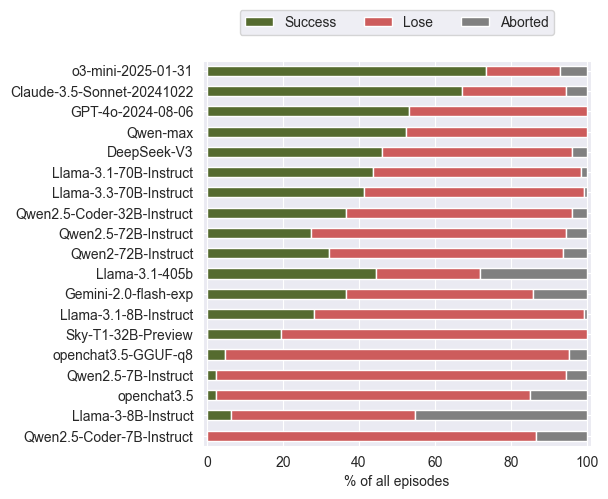

In [11]:
STACK_COLORS = ['darkolivegreen', 'indianred', 'gray']

df_aux = raw_df[raw_df.metric.isin(utils.GAMEPLAY_METRICS)]
df_aux = df_aux.replace(model_name_dict)

df_aux = (df_aux.pivot(index=['game', 'model', 'experiment', 'episode'],
                       columns='metric',
                       values='value')
                .reset_index()
                .drop(columns=['game', 'experiment', 'episode'])
                .groupby('model')
                .sum()
                .sort_values(axis=1, by='metric', ascending=False))
percs = 100 * df_aux.div(df_aux.sum(axis=1), axis=0)
order = clem_df.sort_values(by='-, clemscore').index
percs = percs.reindex(order)

percs.plot(kind='barh',
           stacked=True,
           figsize=(5, 5),
           colormap=ListedColormap(STACK_COLORS))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncols=3)
plt.xlabel('% of all episodes')
plt.xlim(-1, 101)
plt.ylabel('')
plt.show()

Bar plot with sorted clemscores:

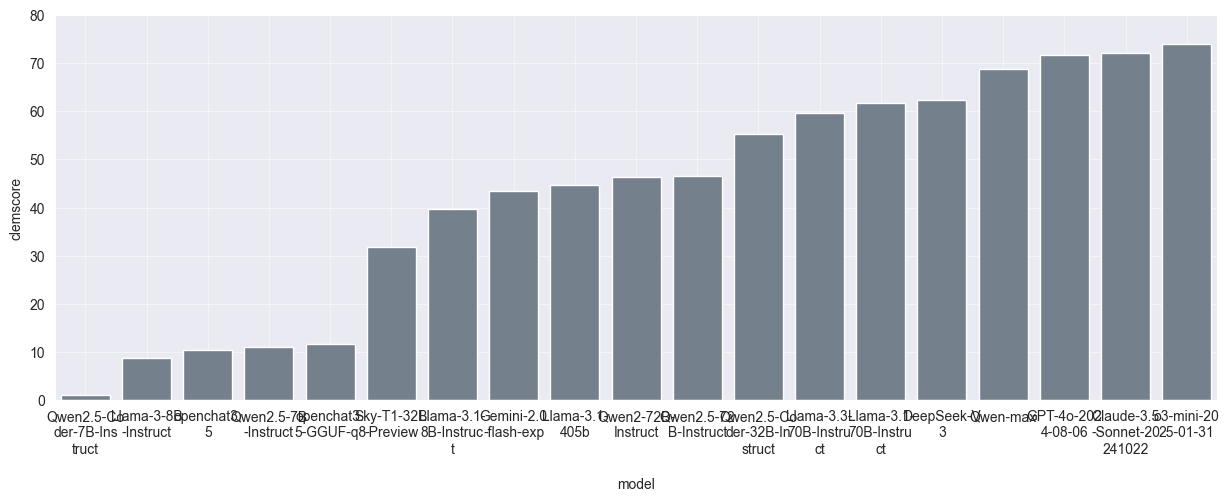

In [12]:
clem_aux = clem_df.sort_values(by='-, clemscore').reset_index(names='model').replace(model_name_dict)
# warning, if models have matching names up the limit, results will be wrongly merged!
clem_aux['model'] = clem_aux['model'].apply(lambda x: f'{x[:10]}\n{x[10:20]}\n{x[20:30]}\n{x[30:]}')

fig = plt.figure(figsize=(15, 5))
sns.barplot(clem_aux, x='model', y='-, clemscore', color='slategray')
# plt.ylim(-5, 105)
plt.ylim(0, 80)
plt.ylabel('clemscore')
plt.grid(alpha=0.5)
plt.show()

Omit models for which all episodes were aborted due to not following prompted format for detail analysis:

In [13]:
all_abort_models = ["LLaMA2-13B-Tiefighter"]
game_df = game_df.query('model not in ["LLaMA2-13B-Tiefighter"]')
game_df

,game,model,experiment,episode,metric,value
0,adventuregame,Claude-3.5-Sonnet-20241022,basic-easy,episode_0,Violated Request Count,0.0
1,adventuregame,Claude-3.5-Sonnet-20241022,basic-easy,episode_0,Parsed Request Count,10.0
2,adventuregame,Claude-3.5-Sonnet-20241022,basic-easy,episode_0,Request Count,10.0
3,adventuregame,Claude-3.5-Sonnet-20241022,basic-easy,episode_0,Request Success Ratio,1.0
4,adventuregame,Claude-3.5-Sonnet-20241022,basic-easy,episode_0,hallucination_count,0.0
...,...,...,...,...,...,...
99707,adventuregame,Sky-T1-32B-Preview,planning-hard-invlimit,episode_5,Played,1.0
99708,adventuregame,Sky-T1-32B-Preview,planning-hard-invlimit,episode_6,Played,1.0
99709,adventuregame,Sky-T1-32B-Preview,planning-hard-invlimit,episode_7,Played,1.0
99710,adventuregame,Sky-T1-32B-Preview,planning-hard-invlimit,episode_8,Played,1.0


## Failure metrics
### Failures by IF interpreter phase

In [14]:
failures_by_phase_df = game_df.query('metric in ["action_parsing_fail", "action_resolution_fail"]')
failures_by_phase_df

,game,model,experiment,episode,metric,value
5,adventuregame,Claude-3.5-Sonnet-20241022,basic-easy,episode_0,action_parsing_fail,0.0
6,adventuregame,Claude-3.5-Sonnet-20241022,basic-easy,episode_0,action_resolution_fail,0.0
45,adventuregame,Claude-3.5-Sonnet-20241022,basic-easy,episode_1,action_parsing_fail,0.0
46,adventuregame,Claude-3.5-Sonnet-20241022,basic-easy,episode_1,action_resolution_fail,0.0
85,adventuregame,Claude-3.5-Sonnet-20241022,basic-easy,episode_10,action_parsing_fail,0.0
...,...,...,...,...,...,...
97166,adventuregame,Sky-T1-32B-Preview,planning-hard-invlimit,episode_7,action_resolution_fail,9.0
97205,adventuregame,Sky-T1-32B-Preview,planning-hard-invlimit,episode_8,action_parsing_fail,47.0
97206,adventuregame,Sky-T1-32B-Preview,planning-hard-invlimit,episode_8,action_resolution_fail,0.0
97245,adventuregame,Sky-T1-32B-Preview,planning-hard-invlimit,episode_9,action_parsing_fail,0.0


Bar plot showing failures by phase for all models over all experiments:

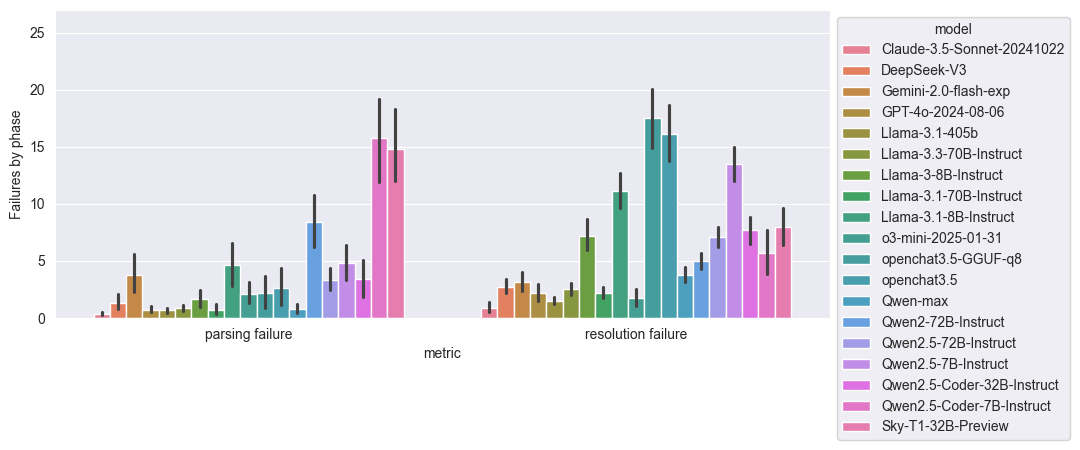

In [15]:
fig, ax = plt.subplots(figsize=(10, 4))

g = sns.barplot(failures_by_phase_df.replace(metric_name_dict),
                x='metric',
                y='value',
                hue='model',
                ax=ax)
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
plt.ylim(0, 27)
plt.ylabel("Failures by phase")

plt.show()

Dataframe with parsed request counts, ie actions passed to the IF interpreter (used to calculate failure ratios):

In [16]:
parsed_df = game_df[game_df.metric == "Parsed Request Count"].groupby(["model"]).sum()
parsed_df = parsed_df.drop(columns=["game", 'experiment', 'episode', 'metric'])
parsed_df

,value
model,
Claude-3.5-Sonnet-20241022,2515.0
DeepSeek-V3,3367.0
GPT-4o-2024-08-06,3094.0
Gemini-2.0-flash-exp,3335.0
Llama-3-8B-Instruct,2683.0
Llama-3.1-405b,2407.0
Llama-3.1-70B-Instruct,2975.0
Llama-3.1-8B-Instruct,4905.0
Llama-3.3-70B-Instruct,3026.0


Counts of failures by phase for all models over all experiments:

In [17]:
failures_by_phase_counts = failures_by_phase_df.replace(metric_name_dict).groupby(['model', 'metric']).sum()
failures_by_phase_counts = failures_by_phase_counts.drop(columns=["game", 'experiment', 'episode'])
failures_by_phase_counts

value
model                      metric                    
Claude-3.5-Sonnet-20241022 parsing failure       46.0
                           resolution failure   112.0
DeepSeek-V3                parsing failure      171.0
                           resolution failure   353.0
GPT-4o-2024-08-06          parsing failure       94.0
                           resolution failure   279.0
Gemini-2.0-flash-exp       parsing failure      487.0
                           resolution failure   403.0
Llama-3-8B-Instruct        parsing failure      212.0
                           resolution failure   923.0
Llama-3.1-405b             parsing failure       86.0
                           resolution failure   190.0
Llama-3.1-70B-Instruct     parsing failure       94.0
                           resolution failure   282.0
Llama-3.1-8B-Instruct      parsing failure      597.0
                           resolution failure  1426.0
Llama-3.3-70B-Instruct     parsing failure      108.0
                           resolution failure   322.0
Qwen-max                   parsing failure      103.0
                           resolution failure   482.0
Qwen2-72B-Instruct         parsing failure     1078.0
                           resolution failure   636.0
Qwen2.5-72B-Instruct       parsing failure      423.0
                           resolution failure   908.0
Qwen2.5-7B-Instruct        parsing failure      616.0
                           resolution failure  1733.0
Qwen2.5-Coder-32B-Instruct parsing failure      432.0
                           resolution failure   986.0
Qwen2.5-Coder-7B-Instruct  parsing failure     2018.0
                           resolution failure   726.0
Sky-T1-32B-Preview         parsing failure     1900.0
                           resolution failure  1019.0
o3-mini-2025-01-31         parsing failure      274.0
                           resolution failure   224.0
openchat3.5                parsing failure      338.0
                           resolution failure  2063.0
openchat3.5-GGUF-q8        parsing failure      283.0
                           resolution failure  2243.0

Ratios of failures by phase for all models over all experiments (calculated by dividing failures counts by parsed request counts):

In [18]:
failures_by_phase_ratios = failures_by_phase_counts / parsed_df
failures_by_phase_ratios

value
model                      metric                      
Claude-3.5-Sonnet-20241022 parsing failure     0.018290
                           resolution failure  0.044533
DeepSeek-V3                parsing failure     0.050787
                           resolution failure  0.104841
GPT-4o-2024-08-06          parsing failure     0.030381
                           resolution failure  0.090175
Gemini-2.0-flash-exp       parsing failure     0.146027
                           resolution failure  0.120840
Llama-3-8B-Instruct        parsing failure     0.079016
                           resolution failure  0.344018
Llama-3.1-405b             parsing failure     0.035729
                           resolution failure  0.078936
Llama-3.1-70B-Instruct     parsing failure     0.031597
                           resolution failure  0.094790
Llama-3.1-8B-Instruct      parsing failure     0.121713
                           resolution failure  0.290724
Llama-3.3-70B-Instruct     parsing failure     0.035691
                           resolution failure  0.106411
Qwen-max                   parsing failure     0.030276
                           resolution failure  0.141681
Qwen2-72B-Instruct         parsing failure     0.252814
                           resolution failure  0.149156
Qwen2.5-72B-Instruct       parsing failure     0.097668
                           resolution failure  0.209651
Qwen2.5-7B-Instruct        parsing failure     0.107994
                           resolution failure  0.303822
Qwen2.5-Coder-32B-Instruct parsing failure     0.097605
                           resolution failure  0.222775
Qwen2.5-Coder-7B-Instruct  parsing failure     0.364260
                           resolution failure  0.131047
Sky-T1-32B-Preview         parsing failure     0.334507
                           resolution failure  0.179401
o3-mini-2025-01-31         parsing failure     0.093039
                           resolution failure  0.076061
openchat3.5                parsing failure     0.078843
                           resolution failure  0.481222
openchat3.5-GGUF-q8        parsing failure     0.063368
                           resolution failure  0.502239

Overview/model comparison stacked bar plot for successful actions and failures by phase:

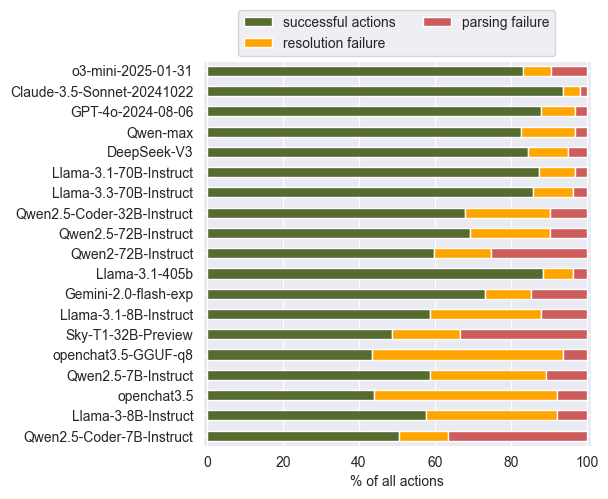

In [19]:
STACK_COLORS = ['darkolivegreen', 'orange', 'indianred']

phase_failures = ["action_parsing_fail", "action_resolution_fail", "successful_actions"]

df_aux = game_df[game_df.metric.isin(phase_failures)]
df_aux = df_aux.replace(metric_name_dict)

df_aux = (df_aux.pivot(index=['game', 'model', 'experiment', 'episode'],
                       columns='metric',
                       values='value')
                .reset_index()
                .drop(columns=['game', 'experiment', 'episode'])
                .groupby('model')
                .sum()
                .sort_values(axis=1, by='metric', ascending=False))
percs = 100 * df_aux.div(df_aux.sum(axis=1), axis=0)
order = clem_df.query('index not in ["LLaMA2-13B-Tiefighter"]').sort_values(by='-, clemscore').index
percs = percs.reindex(order)

percs.plot(kind='barh',
           stacked=True,
           figsize=(5, 5),
           colormap=ListedColormap(STACK_COLORS))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncols=2)
plt.xlabel('% of all actions')
plt.xlim(-1, 101)
plt.ylabel('')
plt.show()

### Parsing failures
Dataframe with parsing failure counts/ratios:
Note: While "undefined_action" and "undefined_argument_type" did not occur in the v1 results, they are implemented, and thus not omitted here.

In [20]:
parsing_failures_df = game_df.query('metric in ["lark_exception", "malformed_command", "undefined_action", "undefined_action_verb", "undefined_repr_str", "undefined_argument_type"]')
parsing_failures_df = parsing_failures_df.replace(metric_name_dict)
parsing_failures_counts = parsing_failures_df.groupby(['model', 'metric']).sum()
parsing_failures_counts = parsing_failures_counts.drop(columns=["game", 'experiment', 'episode'])
parsing_failures_counts['Ratio'] = parsing_failures_counts / parsed_df
parsing_failures_counts = parsing_failures_counts.rename(columns={"value": "Count"})
parsing_failures_counts

Count     Ratio
model                      metric                                
Claude-3.5-Sonnet-20241022 malformed command        2.0  0.000795
                           out of grammar           0.0  0.000000
                           undefined action type    0.0  0.000000
                           undefined action verb   37.0  0.014712
                           undefined antecedent     0.0  0.000000
...                                                 ...       ...
openchat3.5-GGUF-q8        out of grammar           0.0  0.000000
                           undefined action type    0.0  0.000000
                           undefined action verb   97.0  0.021720
                           undefined antecedent     0.0  0.000000
                           undefined noun         129.0  0.028885

[114 rows x 2 columns]

In [21]:
parsing_failures_counts.style.format(subset="Count", precision=0).format(subset="Ratio", precision=3).to_latex('results/parsing_failures_table.tex', clines="skip-last;data")

Overview/model comparison stacked bar plot for parsing failures:
Note: Non-occurring parsing failure types are omitted here.

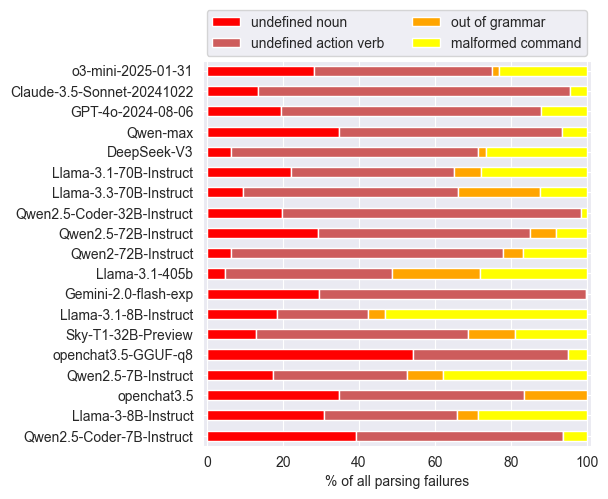

In [22]:
STACK_COLORS = ['red', 'indianred', 'orange', 'yellow']

parse_failures = ["lark_exception", "malformed_command", "undefined_action_verb", "undefined_repr_str"]

df_aux = game_df[game_df.metric.isin(parse_failures)]
df_aux = df_aux.replace(metric_name_dict)

df_aux = (df_aux.pivot(index=['game', 'model', 'experiment', 'episode'],
                       columns='metric',
                       values='value')
                .reset_index()
                .drop(columns=['game', 'experiment', 'episode'])
                .groupby('model')
                .sum()
                .sort_values(axis=1, by='metric', ascending=False))
percs = 100 * df_aux.div(df_aux.sum(axis=1), axis=0)
order = clem_df.query('index not in ["LLaMA2-13B-Tiefighter"]').sort_values(by='-, clemscore').index
percs = percs.reindex(order)

percs.plot(kind='barh',
           stacked=True,
           figsize=(5, 5),
           colormap=ListedColormap(STACK_COLORS))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncols=2)
plt.xlabel('% of all parsing failures')
plt.xlim(-1, 101)
plt.ylabel('')
plt.show()

### Room/navigation failures
Dataframe with room/navigation failure counts/ratios:
Note: While "thing_arg1_room" and "thing_arg2_room" did not occur in the v1 results, they are implemented, and thus not omitted here.

In [23]:
room_failures_df = game_df.query('metric in ["not_room_type", "no_exit_to", "manipulating_room", "other_room_argument", "thing_arg1_room", "thing_arg2_room"]')
room_failures_df = room_failures_df.replace(metric_name_dict)
room_failures_counts = room_failures_df.groupby(['model', 'metric']).sum()
room_failures_counts = room_failures_counts.drop(columns=["game", 'experiment', 'episode'])
room_failures_counts['ratio'] = room_failures_counts / parsed_df
room_failures_counts

value     ratio
model                      metric                                      
Claude-3.5-Sonnet-20241022 going to non-adjacent room    38.0  0.015109
                           interacting with other room    1.0  0.000398
                           manipulating room              0.0  0.000000
DeepSeek-V3                going to non-adjacent room   156.0  0.046332
                           interacting with other room   28.0  0.008316
                           manipulating room              0.0  0.000000
GPT-4o-2024-08-06          going to non-adjacent room   109.0  0.035229
                           interacting with other room    2.0  0.000646
                           manipulating room              0.0  0.000000
Gemini-2.0-flash-exp       going to non-adjacent room    82.0  0.024588
                           interacting with other room   13.0  0.003898
                           manipulating room              5.0  0.001499
Llama-3-8B-Instruct        going to non-adjacent room   130.0  0.048453
                           interacting with other room    2.0  0.000745
                           manipulating room              0.0  0.000000
Llama-3.1-405b             going to non-adjacent room   117.0  0.048608
                           interacting with other room    2.0  0.000831
                           manipulating room              2.0  0.000831
Llama-3.1-70B-Instruct     going to non-adjacent room   131.0  0.044034
                           interacting with other room    7.0  0.002353
                           manipulating room              0.0  0.000000
Llama-3.1-8B-Instruct      going to non-adjacent room   326.0  0.066463
                           interacting with other room   23.0  0.004689
                           manipulating room              0.0  0.000000
Llama-3.3-70B-Instruct     going to non-adjacent room   176.0  0.058163
                           interacting with other room    2.0  0.000661
                           manipulating room              0.0  0.000000
Qwen-max                   going to non-adjacent room   272.0  0.079953
                           interacting with other room    0.0  0.000000
                           manipulating room              0.0  0.000000
Qwen2-72B-Instruct         going to non-adjacent room   315.0  0.073874
                           interacting with other room   19.0  0.004456
                           manipulating room              0.0  0.000000
Qwen2.5-72B-Instruct       going to non-adjacent room   359.0  0.082891
                           interacting with other room    2.0  0.000462
                           manipulating room              0.0  0.000000
Qwen2.5-7B-Instruct        going to non-adjacent room   420.0  0.073633
                           interacting with other room   35.0  0.006136
                           manipulating room              8.0  0.001403
Qwen2.5-Coder-32B-Instruct going to non-adjacent room   410.0  0.092634
                           interacting with other room    0.0  0.000000
                           manipulating room              0.0  0.000000
Qwen2.5-Coder-7B-Instruct  going to non-adjacent room    41.0  0.007401
                           interacting with other room    0.0  0.000000
                           manipulating room              0.0  0.000000
Sky-T1-32B-Preview         going to non-adjacent room   312.0  0.054930
                           interacting with other room    0.0  0.000000
                           manipulating room              2.0  0.000352
o3-mini-2025-01-31         going to non-adjacent room    45.0  0.015280
                           interacting with other room    1.0  0.000340
                           manipulating room              1.0  0.000340
openchat3.5                going to non-adjacent room   422.0  0.098437
                           interacting with other room    2.0  0.000467
                           manipulating room             52.0  0.012130
openchat3.5-GGUF-q8     

Overview/model comparison stacked bar plot for room/navigation failures:
Note: Non-occurring room/navigation failure types are omitted here.

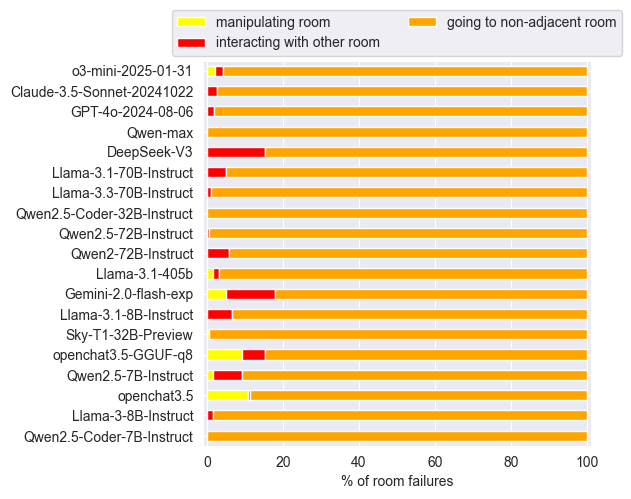

In [24]:
STACK_COLORS = ['yellow', 'orange', 'indianred', 'red', 'yellow', 'orange']

room_failures = ["not_room_type", "no_exit_to", "manipulating_room", "other_room_argument"]

df_aux = game_df[game_df.metric.isin(room_failures)]
df_aux = df_aux.replace(metric_name_dict)

df_aux = (df_aux.pivot(index=['game', 'model', 'experiment', 'episode'],
                       columns='metric',
                       values='value')
                .reset_index()
                .drop(columns=['game', 'experiment', 'episode'])
                .groupby('model')
                .sum()
                .sort_values(axis=1, by='metric', ascending=False))
percs = 100 * df_aux.div(df_aux.sum(axis=1), axis=0)
order = clem_df.query('index not in ["LLaMA2-13B-Tiefighter"]').sort_values(by='-, clemscore').index
percs = percs.reindex(order)

percs.plot(kind='barh',
           stacked=True,
           figsize=(5, 5),
           colormap=ListedColormap(STACK_COLORS))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncols=2)
plt.xlabel('% of room failures')
plt.xlim(-1, 101)
plt.ylabel('')
plt.show()

### Entity-related failures
Dataframe with entity-related failure counts/ratios:

In [25]:
entity_failures_df = game_df.query('metric in ["entity_not_accessible", "entity_already_inventory", "entity_state_mismatch", "entity_trait_mismatch", "inventory_limit_exceeded"]')
entity_failures_df = entity_failures_df.replace(metric_name_dict)
entity_failures_counts = entity_failures_df.groupby(['model', 'metric']).sum()
entity_failures_counts = entity_failures_counts.drop(columns=["game", 'experiment', 'episode'])
entity_failures_counts['ratio'] = entity_failures_counts / parsed_df
entity_failures_counts

value     ratio
model                      metric                                       
Claude-3.5-Sonnet-20241022 entity already in inventory     7.0  0.002783
                           entity not accessible          50.0  0.019881
                           entity state mismatch           6.0  0.002386
                           entity trait mismatch           0.0  0.000000
                           inventory limit exceeded        5.0  0.001988
...                                                        ...       ...
openchat3.5-GGUF-q8        entity already in inventory    13.0  0.002911
                           entity not accessible        1552.0  0.347515
                           entity state mismatch          76.0  0.017017
                           entity trait mismatch           0.0  0.000000
                           inventory limit exceeded       20.0  0.004478

[95 rows x 2 columns]

Overview/model comparison stacked bar plot for entity-related failures:

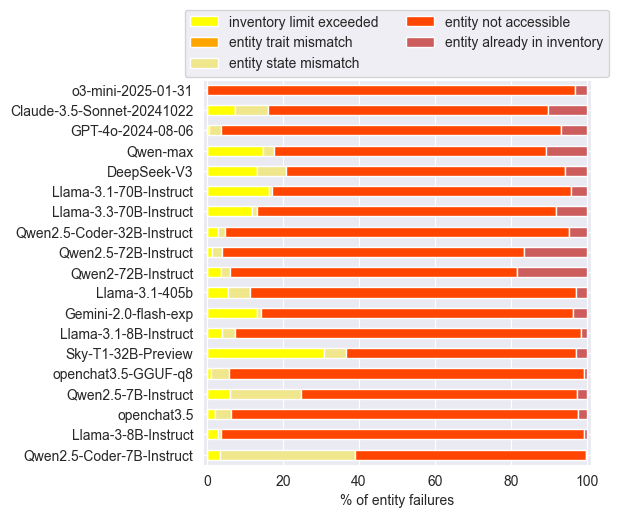

In [26]:
STACK_COLORS = ['yellow', 'orange', 'red', 'khaki', 'orangered', 'indianred']

entity_failures = ["entity_not_accessible", "entity_already_inventory", "entity_state_mismatch", "entity_trait_mismatch", "inventory_limit_exceeded"]

df_aux = game_df[game_df.metric.isin(entity_failures)]
df_aux = df_aux.replace(metric_name_dict)

df_aux = (df_aux.pivot(index=['game', 'model', 'experiment', 'episode'],
                       columns='metric',
                       values='value')
                .reset_index()
                .drop(columns=['game', 'experiment', 'episode'])
                .groupby('model')
                .sum()
                .sort_values(axis=1, by='metric', ascending=False))
percs = 100 * df_aux.div(df_aux.sum(axis=1), axis=0)
order = clem_df.query('index not in ["LLaMA2-13B-Tiefighter"]').sort_values(by='-, clemscore').index
percs = percs.reindex(order)

percs.plot(kind='barh',
           stacked=True,
           figsize=(5, 5),
           colormap=ListedColormap(STACK_COLORS))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncols=2)
plt.xlabel('% of entity failures')
plt.xlim(-1, 101)
plt.ylabel('')
plt.show()

## Overview tables
Dispersion metrics over all episodes. Note that this uses groupby, which will ignore NaN values, according to the clembench documentation!

In [27]:
stats_df = build_dispersion_table(['game', 'model', 'metric'], game_df) # could also use raw_df for results for all games
stats_df

mean  \
game          model                      metric                               
adventuregame Claude-3.5-Sonnet-20241022 Aborted                   0.054688   
                                         Lose                      0.273438   
                                         Main Score               76.302083   
                                         Parsed Request Count     19.648438   
                                         Played                    0.945312   
...                                                                     ...   
              openchat3.5-GGUF-q8        undefined_action          0.000000   
                                         undefined_action_verb     0.757812   
                                         undefined_argument_type   0.000000   
                                         undefined_repr_str        1.007812   
                                         world_state_discrepancy   0.000000   

                                                                        std  \
game          model                      metric                               
adventuregame Claude-3.5-Sonnet-20241022 Aborted                   0.228263   
                                         Lose                      0.447475   
                                         Main Score               38.600256   
                                         Parsed Request Count      9.268174   
                                         Played                    0.228263   
...                                                                     ...   
              openchat3.5-GGUF-q8        undefined_action          0.000000   
                                         undefined_action_verb     4.830588   
                                         undefined_argument_type   0.000000   
                                         undefined_repr_str        6.080168   
                                         world_state_discrepancy   0.000000   

                                                                          var  \
game          model                      metric                                 
adventuregame Claude-3.5-Sonnet-20241022 Aborted                     0.052104   
                                         Lose                        0.200234   
                                         Main Score               1489.979768   
                                         Parsed Request Count       85.899053   
                                         Played                      0.052104   
...                                                                       ...   
              openchat3.5-GGUF-q8        undefined_action            0.000000   
                                         undefined_action_verb      23.334584   
                                         undefined_argument_type     0.000000   
                                         undefined_repr_str         36.968442   
                                         world_state_discrepancy     0.000000   

                                                                  median  \
game          model                      metric                            
adventuregame Claude-3.5-Sonnet-20241022 Aborted                     0.0   
                                         Lose                        0.0   
                                         Main Score                100.0   
                                         Parsed Request Count       18.5   
                                         Played                      1.0   
...                                                                  ...   
              openchat3.5-GGUF-q8        undefined_action            0.0   
                                         undefined_action_verb       0.0   
                                         undefined_argument_type     0.0   
                                         undefined_repr_str          0.0   
                                         world_st

In [28]:
failure_stats_by_phase_df = stats_df.query('metric in ["action_parsing_fail", "action_resolution_fail"]')
failure_stats_by_phase_df

mean  \
game          model                      metric                              
adventuregame Claude-3.5-Sonnet-20241022 action_parsing_fail      0.359375   
                                         action_resolution_fail   0.875000   
              DeepSeek-V3                action_parsing_fail      1.335938   
                                         action_resolution_fail   2.757812   
              GPT-4o-2024-08-06          action_parsing_fail      0.734375   
                                         action_resolution_fail   2.179688   
              Gemini-2.0-flash-exp       action_parsing_fail      3.804688   
                                         action_resolution_fail   3.148438   
              Llama-3-8B-Instruct        action_parsing_fail      1.656250   
                                         action_resolution_fail   7.210938   
              Llama-3.1-405b             action_parsing_fail      0.671875   
                                         action_resolution_fail   1.484375   
              Llama-3.1-70B-Instruct     action_parsing_fail      0.734375   
                                         action_resolution_fail   2.203125   
              Llama-3.1-8B-Instruct      action_parsing_fail      4.664062   
                                         action_resolution_fail  11.140625   
              Llama-3.3-70B-Instruct     action_parsing_fail      0.843750   
                                         action_resolution_fail   2.515625   
              Qwen-max                   action_parsing_fail      0.804688   
                                         action_resolution_fail   3.765625   
              Qwen2-72B-Instruct         action_parsing_fail      8.421875   
                                         action_resolution_fail   4.968750   
              Qwen2.5-72B-Instruct       action_parsing_fail      3.304688   
                                         action_resolution_fail   7.093750   
              Qwen2.5-7B-Instruct        action_parsing_fail      4.812500   
                                         action_resolution_fail  13.539062   
              Qwen2.5-Coder-32B-Instruct action_parsing_fail      3.375000   
                                         action_resolution_fail   7.703125   
              Qwen2.5-Coder-7B-Instruct  action_parsing_fail     15.765625   
                                         action_resolution_fail   5.671875   
              Sky-T1-32B-Preview         action_parsing_fail     14.843750   
                                         action_resolution_fail   7.960938   
              o3-mini-2025-01-31         action_parsing_fail      2.140625   
                                         action_resolution_fail   1.750000   
              openchat3.5                action_parsing_fail      2.640625   
                                         action_resolution_fail  16.117188   
              openchat3.5-GGUF-q8        action_parsing_fail      2.210938   
                                         action_resolution_fail  17.523438   

                                                                       std  \
game          model                      metric                              
adventuregame Claude-3.5-Sonnet-20241022 action_parsing_fail      0.800928   
                                         action_resolution_fail   2.593147   
              DeepSeek-V3                action_parsing_fail      3.611612   
                                         action_resolution_fail   3.619166   
              GPT-4o-2024-08-06          action_parsing_fail      1.709097   
                                         action_resolution_fail   4.472899   
              Gemini-2.0-flash-exp       action_parsing_fail      9.498494   
                                         action_resolution_fail   4.788585   
              Llama-3-8B-Instruct        action_parsing_fail      4.249016   
                                         action_resolution_fail   8.121763   
             

Break results down by experiment:

In [29]:
detailed_stats_df = build_dispersion_table(['game', 'model', 'experiment', 'metric'], game_df) # could also use raw_df for results for all games
detailed_stats_df

mean  \
game          model                      experiment             metric                             
adventuregame Claude-3.5-Sonnet-20241022 basic-easy             Aborted                   0.0000   
                                                                Lose                      0.2500   
                                                                Main Score               75.0000   
                                                                Parsed Request Count     12.4375   
                                                                Played                    1.0000   
...                                                                                          ...   
              openchat3.5-GGUF-q8        planning-hard-invlimit undefined_action          0.0000   
                                                                undefined_action_verb     0.3125   
                                                                undefined_argument_type   0.0000   
                                                                undefined_repr_str        5.4375   
                                                                world_state_discrepancy   0.0000   

                                                                                               std  \
game          model                      experiment             metric                               
adventuregame Claude-3.5-Sonnet-20241022 basic-easy             Aborted                   0.000000   
                                                                Lose                      0.447214   
                                                                Main Score               44.721360   
                                                                Parsed Request Count      2.032035   
                                                                Played                    0.000000   
...                                                                                            ...   
              openchat3.5-GGUF-q8        planning-hard-invlimit undefined_action          0.000000   
                                                                undefined_action_verb     0.793200   
                                                                undefined_argument_type   0.000000   
                                                                undefined_repr_str       14.859200   
                                                                world_state_discrepancy   0.000000   

                                                                                                 var  \
game          model                      experiment             metric                                 
adventuregame Claude-3.5-Sonnet-20241022 basic-easy             Aborted                     0.000000   
                                                                Lose                        0.200000   
                                                                Main Score               2000.000000   
                                                                Parsed Request Count        4.129167   
                                                                Played                      0.000000   
...                                                                                              ...   
              openchat3.5-GGUF-q8        planning-hard-invlimit undefined_action            0.000000   
                                                                undefined_action_verb       0.629167   
                                                                undefined_argument_type     0.000000   
                                                                undefined_repr_str        220.795833   
                                                                world_state_discrepancy     0.000000   

                                                                                         median  \
game        

In [30]:
stats_df.to_csv('results/adventuregame_stats.csv')
detailed_stats_df.to_csv('results/adventuregame_stats_detailed.csv')

In [31]:
stats_df.to_html('results/adventuregame_stats.html')
detailed_stats_df.to_html('results/adventuregame_stats_detailed.html')

Condensed tables:

In [32]:
game_df

,game,model,experiment,episode,metric,value
0,adventuregame,Claude-3.5-Sonnet-20241022,basic-easy,episode_0,Violated Request Count,0.0
1,adventuregame,Claude-3.5-Sonnet-20241022,basic-easy,episode_0,Parsed Request Count,10.0
2,adventuregame,Claude-3.5-Sonnet-20241022,basic-easy,episode_0,Request Count,10.0
3,adventuregame,Claude-3.5-Sonnet-20241022,basic-easy,episode_0,Request Success Ratio,1.0
4,adventuregame,Claude-3.5-Sonnet-20241022,basic-easy,episode_0,hallucination_count,0.0
...,...,...,...,...,...,...
99707,adventuregame,Sky-T1-32B-Preview,planning-hard-invlimit,episode_5,Played,1.0
99708,adventuregame,Sky-T1-32B-Preview,planning-hard-invlimit,episode_6,Played,1.0
99709,adventuregame,Sky-T1-32B-Preview,planning-hard-invlimit,episode_7,Played,1.0
99710,adventuregame,Sky-T1-32B-Preview,planning-hard-invlimit,episode_8,Played,1.0


In [33]:
selected_stats_df = game_df.drop(columns=["game"])
selected_metrics_list = ["Main Score", "Played", "Success", "action_parsing_fail", "action_resolution_fail", "successful_actions"]
selected_stats_df = selected_stats_df.query('metric in ["Main Score", "Played"]')
selected_stats_df = build_dispersion_table(['model', 'experiment', 'metric'], selected_stats_df)
selected_stats_df = selected_stats_df.drop(columns=["var", "median", "max", "min", "skew"])
selected_stats_df = selected_stats_df.rename(metric_name_dict)
selected_stats_df = selected_stats_df.rename({"Main Score": "Score"})
selected_stats_df = selected_stats_df.reset_index()
selected_stats_df = pd.pivot_table(selected_stats_df, index=['model', 'experiment'], columns='metric')
selected_stats_df

mean             \
metric                                             Played      Score   
model                      experiment                                  
Claude-3.5-Sonnet-20241022 basic-easy              1.0000  75.000000   
                           basic-easy-invlimit     1.0000  68.750000   
                           basic-hard              1.0000  91.666667   
                           basic-hard-invlimit     1.0000  85.416667   
                           planning-easy           0.9375  62.500000   
...                                                   ...        ...   
openchat3.5-GGUF-q8        basic-hard-invlimit     1.0000   2.083333   
                           planning-easy           1.0000  16.666667   
                           planning-easy-invlimit  0.8750  14.583333   
                           planning-hard           0.8750   2.083333   
                           planning-hard-invlimit  0.8750   2.083333   

                                                        std             
metric                                               Played      Score  
model                      experiment                                   
Claude-3.5-Sonnet-20241022 basic-easy              0.000000  44.721360  
                           basic-easy-invlimit     0.000000  47.871355  
                           basic-hard              0.000000  14.907120  
                           basic-hard-invlimit     0.000000  20.971762  
                           planning-easy           0.250000  50.000000  
...                                                     ...        ...  
openchat3.5-GGUF-q8        basic-hard-invlimit     0.000000   8.333333  
                           planning-easy           0.000000  29.814240  
                           planning-easy-invlimit  0.341565  27.131368  
                           planning-hard           0.341565   8.333333  
                           planning-hard-invlimit  0.341565   8.333333  

[152 rows x 4 columns]

In [34]:
selected_stats_df.to_html("results/selected_stats.html")

In [35]:
selected_stats_styled = selected_stats_df.style.set_table_styles([
    {'selector': 'toprule', 'props': ':hline;'},
    {'selector': 'bottomrule', 'props': ':hline;'},
], overwrite=False).format(precision=2)
selected_stats_styled.to_latex("results/selected_stats.tex", clines="skip-last;data")

Limit to selected top models:

In [100]:
top_stats_df = game_df.drop(columns=["game"])
top_stats_df = top_stats_df.query('metric in ["Main Score", "Played", "Success", "hallucination_count"]')
top_stats_df = top_stats_df.query("model in ['o3-mini-2025-01-31', 'Claude-3.5-Sonnet-20241022', 'Llama-3.1-70B-Instruct', 'Qwen2.5-Coder-32B-Instruct', 'GPT-4o-2024-08-06']")
top_stats_df = build_dispersion_table(['model', 'experiment', 'metric'], top_stats_df)
top_stats_df = top_stats_df.drop(columns=["var", "median", "max", "min", "skew", "std"])
top_stats_df = top_stats_df.rename(metric_name_dict)
top_stats_df = top_stats_df.rename({"Main Score": "Quality"})
top_stats_df = top_stats_df.rename({"Played": "% Played"})
top_stats_df = top_stats_df.rename({"Success": "% Success"})
top_stats_df = top_stats_df.rename({"hallucination_count": "% Hal."})
top_stats_df = top_stats_df.reset_index()
top_stats_df = pd.pivot_table(top_stats_df, index=['model', 'experiment'], columns='metric')
# top_stats_df['clemscore'] = top_stats_df[('mean', '% Played')] * top_stats_df[('mean', 'Quality Score')]
top_stats_df[('metric', 'clemscore')] = top_stats_df[('mean', '% Played')] * top_stats_df[('mean', 'Quality')]
# top_stats_df[('mean', '% Played')] = top_stats_df[('mean', '% Played')] * 100
top_stats_df[('metric', '% Played')] = top_stats_df[('mean', '% Played')] * 100
top_stats_df[('metric', 'Quality')] = top_stats_df[('mean', 'Quality')]
# top_stats_df[('mean', '% Success')] = top_stats_df[('mean', '% Success')] * 100
top_stats_df[('metric', '% Success')] = top_stats_df[('mean', '% Success')] * 100
top_stats_df[('metric', "% Hal.")] = top_stats_df[('mean', "% Hal.")] * 100
top_stats_df = top_stats_df.drop(columns=[("mean", '% Played'), ("mean", '% Success'), ("mean", 'Quality'), ('mean', "% Hal.")])
top_stats_df

metric           \
metric                                             clemscore % Played   
model                      experiment                                   
Claude-3.5-Sonnet-20241022 basic-easy              75.000000   100.00   
                           basic-easy-invlimit     68.750000   100.00   
                           basic-hard              91.666667   100.00   
                           basic-hard-invlimit     85.416667   100.00   
                           planning-easy           58.593750    93.75   
                           planning-easy-invlimit  68.750000   100.00   
                           planning-hard           74.739583    87.50   
                           planning-hard-invlimit  54.687500    75.00   
GPT-4o-2024-08-06          basic-easy              70.833333   100.00   
                           basic-easy-invlimit     77.083333   100.00   
                           basic-hard              77.083333   100.00   
                           basic-hard-invlimit     75.000000   100.00   
                           planning-easy           62.500000   100.00   
                           planning-easy-invlimit  62.500000   100.00   
                           planning-hard           72.916667   100.00   
                           planning-hard-invlimit  75.000000   100.00   
Llama-3.1-70B-Instruct     basic-easy              50.000000   100.00   
                           basic-easy-invlimit     56.250000   100.00   
                           basic-hard              68.750000   100.00   
                           basic-hard-invlimit     68.750000   100.00   
                           planning-easy           62.500000   100.00   
                           planning-easy-invlimit  56.250000   100.00   
                           planning-hard           64.453125    93.75   
                           planning-hard-invlimit  66.406250    93.75   
Qwen2.5-Coder-32B-Instruct basic-easy              79.166667   100.00   
                           basic-easy-invlimit     72.916667   100.00   
                           basic-hard              52.083333   100.00   
                           basic-hard-invlimit     39.583333   100.00   
                           planning-easy           49.088542    81.25   
                           planning-easy-invlimit  64.583333   100.00   
                           planning-hard           52.083333   100.00   
                           planning-hard-invlimit  34.635417    87.50   
o3-mini-2025-01-31         basic-easy              85.416667   100.00   
                           basic-easy-invlimit     76.171875    93.75   
                           basic-hard              87.500000   100.00   
                           basic-hard-invlimit     93.750000   100.00   
                           planning-easy           55.859375    81.25   
                           planning-easy-invlimit  50.781250    81.25   
                           planning-hard           68.359375    93.75   
                           planning-hard-invlimit  80.078125    93.75   

                                                                               
metric                                               Quality % Success % Hal.  
model                      experiment                                          
Claude-3.5-Sonnet-20241022 basic-easy              75.000000     75.00  25.00  
                           basic-easy-invlimit     68.750000     68.75  31.25  
                           basic-hard              91.666667     75.00  18.75  
                           basic-hard-invlimit     85.416667     62.50  31.25  
                           planning-easy           62.500000     62.50  31.25  
                           planning-easy-invlimit  68.750000     68.75  31.25  
                           planning-hard           85.416667     68.75  18.75  
                           planning-hard-invlimit  72.916667     56.25  25.00  
GPT-4o-2024-08-06          basic-e

In [101]:
top_stats_df.to_html("results/top_model_experiment_stats.html")

In [102]:
top_stats_styled = top_stats_df.style.set_table_styles([
    {'selector': 'toprule', 'props': ':hline;'},
    {'selector': 'bottomrule', 'props': ':hline;'},
], overwrite=False).format(precision=2)
top_stats_styled.to_latex("results/top_model_experiment_stats.tex", clines="skip-last;data")

Planning variant:

In [40]:
plan_df = game_df.query('experiment in ["planning-easy", "planning-hard", "planning-easy-invlimit", "planning-hard-invlimit"]')
plan_df

,game,model,experiment,episode,metric,value
640,adventuregame,Claude-3.5-Sonnet-20241022,planning-easy,episode_0,Violated Request Count,0.0
641,adventuregame,Claude-3.5-Sonnet-20241022,planning-easy,episode_0,Parsed Request Count,10.0
642,adventuregame,Claude-3.5-Sonnet-20241022,planning-easy,episode_0,Request Count,10.0
643,adventuregame,Claude-3.5-Sonnet-20241022,planning-easy,episode_0,Request Success Ratio,1.0
644,adventuregame,Claude-3.5-Sonnet-20241022,planning-easy,episode_0,hallucination_count,0.0
...,...,...,...,...,...,...
99707,adventuregame,Sky-T1-32B-Preview,planning-hard-invlimit,episode_5,Played,1.0
99708,adventuregame,Sky-T1-32B-Preview,planning-hard-invlimit,episode_6,Played,1.0
99709,adventuregame,Sky-T1-32B-Preview,planning-hard-invlimit,episode_7,Played,1.0
99710,adventuregame,Sky-T1-32B-Preview,planning-hard-invlimit,episode_8,Played,1.0


In [41]:
selected_plan_df = plan_df.drop(columns=["game"])
selected_plan_df = selected_plan_df.query('metric in ["plan_average_viability_ratio", "plan_followed_ratio", "bad_plan_dismiss_ratio"]')

selected_plan_df = build_dispersion_table(['model', 'experiment', 'metric'], selected_plan_df)
selected_plan_df = selected_plan_df.drop(columns=["var", "median", "max", "min", "skew"])

selected_plan_df = selected_plan_df.rename(metric_name_dict)
selected_plan_df = selected_plan_df.rename({"plan_average_viability_ratio": "Viable", "plan_followed_ratio": "Follow", "bad_plan_dismiss_ratio": "Adapt"})

selected_plan_df = selected_plan_df.reset_index()
selected_plan_df = pd.pivot_table(selected_plan_df, index=['model', 'experiment'], columns='metric')

selected_plan_df

mean            \
metric                                                Adapt    Follow   
model                      experiment                                   
Claude-3.5-Sonnet-20241022 planning-easy           0.985204  0.249798   
                           planning-easy-invlimit  1.000000  0.247190   
                           planning-hard           0.993750  0.165536   
                           planning-hard-invlimit  1.000000  0.082187   
DeepSeek-V3                planning-easy           0.969818  0.160391   
...                                                     ...       ...   
openchat3.5                planning-hard-invlimit  0.832500  0.231042   
openchat3.5-GGUF-q8        planning-easy           0.791684  0.287284   
                           planning-easy-invlimit  0.860595  0.202321   
                           planning-hard           0.857113  0.218199   
                           planning-hard-invlimit  0.747708  0.335833   

                                                                  std  \
metric                                               Viable     Adapt   
model                      experiment                                   
Claude-3.5-Sonnet-20241022 planning-easy           0.167630  0.032262   
                           planning-easy-invlimit  0.163983  0.000000   
                           planning-hard           0.091813  0.025000   
                           planning-hard-invlimit  0.057230  0.000000   
DeepSeek-V3                planning-easy           0.137243  0.039477   
...                                                     ...       ...   
openchat3.5                planning-hard-invlimit  0.261313  0.147811   
openchat3.5-GGUF-q8        planning-easy           0.115625  0.149045   
                           planning-easy-invlimit  0.125327  0.157319   
                           planning-hard           0.174901  0.156985   
                           planning-hard-invlimit  0.141537  0.239455   

                                                                       
metric                                               Follow    Viable  
model                      experiment                                  
Claude-3.5-Sonnet-20241022 planning-easy           0.106859  0.059183  
                           planning-easy-invlimit  0.155333  0.108280  
                           planning-hard           0.071526  0.035389  
                           planning-hard-invlimit  0.068371  0.040368  
DeepSeek-V3                planning-easy           0.146942  0.103975  
...                                                     ...       ...  
openchat3.5                planning-hard-invlimit  0.184362  0.283074  
openchat3.5-GGUF-q8        planning-easy           0.218426  0.147415  
                           planning-easy-invlimit  0.229175  0.183386  
                           planning-hard           0.196226  0.233401  
                           planning-hard-invlimit  0.304746  0.170152  

[76 rows x 6 columns]

In [42]:
selected_plan_styled = selected_plan_df.style.set_table_styles([
    {'selector': 'toprule', 'props': ':hline;'},
    {'selector': 'bottomrule', 'props': ':hline;'},
], overwrite=False).format(precision=2)
selected_plan_styled.to_latex("results/selected_planning.tex", clines="skip-last;data")

Hallucinations:

In [43]:
hallucination_df = game_df[game_df.metric == 'hallucination_count']
hallucination_df

,game,model,experiment,episode,metric,value
4,adventuregame,Claude-3.5-Sonnet-20241022,basic-easy,episode_0,hallucination_count,0.0
44,adventuregame,Claude-3.5-Sonnet-20241022,basic-easy,episode_1,hallucination_count,0.0
84,adventuregame,Claude-3.5-Sonnet-20241022,basic-easy,episode_10,hallucination_count,0.0
124,adventuregame,Claude-3.5-Sonnet-20241022,basic-easy,episode_11,hallucination_count,1.0
164,adventuregame,Claude-3.5-Sonnet-20241022,basic-easy,episode_12,hallucination_count,0.0
...,...,...,...,...,...,...
97084,adventuregame,Sky-T1-32B-Preview,planning-hard-invlimit,episode_5,hallucination_count,1.0
97124,adventuregame,Sky-T1-32B-Preview,planning-hard-invlimit,episode_6,hallucination_count,0.0
97164,adventuregame,Sky-T1-32B-Preview,planning-hard-invlimit,episode_7,hallucination_count,0.0
97204,adventuregame,Sky-T1-32B-Preview,planning-hard-invlimit,episode_8,hallucination_count,0.0


In [44]:
llama3_1_70b_hallu = hallucination_df.query('model == "Llama-3.1-70b-Instruct" and value == 1')
llama3_1_70b_hallu

,game,model,experiment,episode,metric,value


In [45]:
openchat_hallu = hallucination_df.query('model == "openchat3.5" and value == 1')
openchat_hallu

,game,model,experiment,episode,metric,value
56324,adventuregame,openchat3.5,basic-easy,episode_0,hallucination_count,1.0
56404,adventuregame,openchat3.5,basic-easy,episode_10,hallucination_count,1.0
56484,adventuregame,openchat3.5,basic-easy,episode_12,hallucination_count,1.0
56564,adventuregame,openchat3.5,basic-easy,episode_14,hallucination_count,1.0
56604,adventuregame,openchat3.5,basic-easy,episode_15,hallucination_count,1.0
56644,adventuregame,openchat3.5,basic-easy,episode_2,hallucination_count,1.0
56924,adventuregame,openchat3.5,basic-easy,episode_9,hallucination_count,1.0
57004,adventuregame,openchat3.5,planning-easy,episode_1,hallucination_count,1.0
57204,adventuregame,openchat3.5,planning-easy,episode_14,hallucination_count,1.0
57324,adventuregame,openchat3.5,planning-easy,episode_3,hallucination_count,1.0


In [46]:
hallucination_counts = hallucination_df.groupby(['model']).sum()
hallucination_sums = hallucination_counts.iloc[0:19, [4]]
# hallucination_sums['Ratio'] = hallucination_sums.value / 64
hallucination_sums['Percentage'] = (hallucination_sums.value / 128) * 100
hallucination_sums = hallucination_sums.rename(columns = {"value": "Total"})
hallucination_sums

,Total,Percentage
model,,
Claude-3.5-Sonnet-20241022,34.0,26.56250
DeepSeek-V3,54.0,42.18750
GPT-4o-2024-08-06,54.0,42.18750
Gemini-2.0-flash-exp,47.0,36.71875
Llama-3-8B-Instruct,46.0,35.93750
Llama-3.1-405b,41.0,32.03125
Llama-3.1-70B-Instruct,65.0,50.78125
Llama-3.1-8B-Instruct,23.0,17.96875
Llama-3.3-70B-Instruct,71.0,55.46875


In [47]:
hallucination_sums.to_html('results/hallucination_sums.html')

In [48]:
h_styled = hallucination_sums.style.set_table_styles([
    {'selector': 'toprule', 'props': ':hline;'},
    {'selector': 'bottomrule', 'props': ':hline;'},
], overwrite=False).format(subset="Percentage", precision=3).format(subset="Total", precision=0)
h_styled.to_latex('results/hallucination_sums.tex')

In [49]:
h_styled = hallucination_sums.style.format(subset="Percentage", precision=3).format(subset="Total", precision=0).to_latex('results/hallucination_sums.tex', clines="skip-last;data")

In [50]:
detailed_hallucination_df = build_dispersion_table(['model'], hallucination_df)
detailed_hallucination_df

,mean,std,var,median,max,min,skew
model,,,,,,,
Claude-3.5-Sonnet-20241022,0.265625,0.443401,0.196604,0.0,1.0,0.0,1.073950
DeepSeek-V3,0.421875,0.495799,0.245817,0.0,1.0,0.0,0.320150
GPT-4o-2024-08-06,0.421875,0.495799,0.245817,0.0,1.0,0.0,0.320150
Gemini-2.0-flash-exp,0.367188,0.483932,0.234190,0.0,1.0,0.0,0.557601
Llama-3-8B-Instruct,0.359375,0.481703,0.232037,0.0,1.0,0.0,0.593134
Llama-3.1-405b,0.320312,0.468430,0.219427,0.0,1.0,0.0,0.779368
Llama-3.1-70B-Instruct,0.507812,0.501903,0.251907,1.0,1.0,0.0,-0.031626
Llama-3.1-8B-Instruct,0.179688,0.385436,0.148561,0.0,1.0,0.0,1.688463
Llama-3.3-70B-Instruct,0.554688,0.498953,0.248954,1.0,1.0,0.0,-0.222688


## Specific metrics plots
Bar plot overview by model and experiment:

In [51]:
def metric_bar_plot(source_df, metric, max_value=1):
    metric_df = source_df[game_df.metric == metric].sort_values('experiment')
    fig, ax = plt.subplots(figsize=(14, 4))

    g = sns.barplot(metric_df,
                x='experiment',
                y='value',
                hue='model', 
                ax=ax)

    sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
    plt.ylim(0, max_value)
    plt.ylabel(metric)

    plt.show()

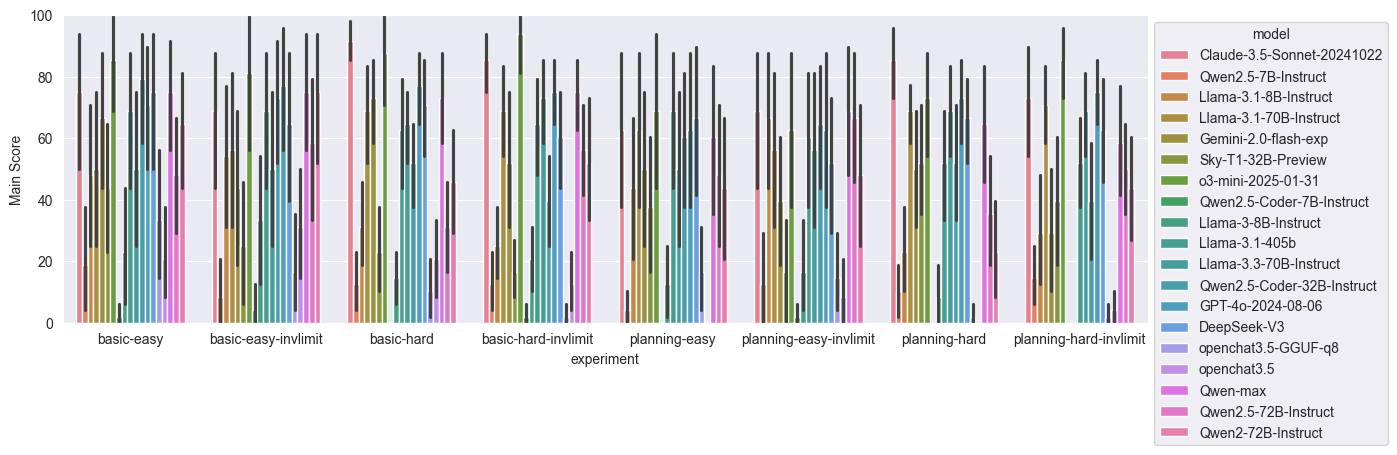

In [52]:
metric_bar_plot(game_df, "Main Score", max_value=100)

Planning:

C:\Users\JJ\AppData\Local\Temp\ipykernel_20736\8844963.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  metric_df = source_df[game_df.metric == metric].sort_values('experiment')


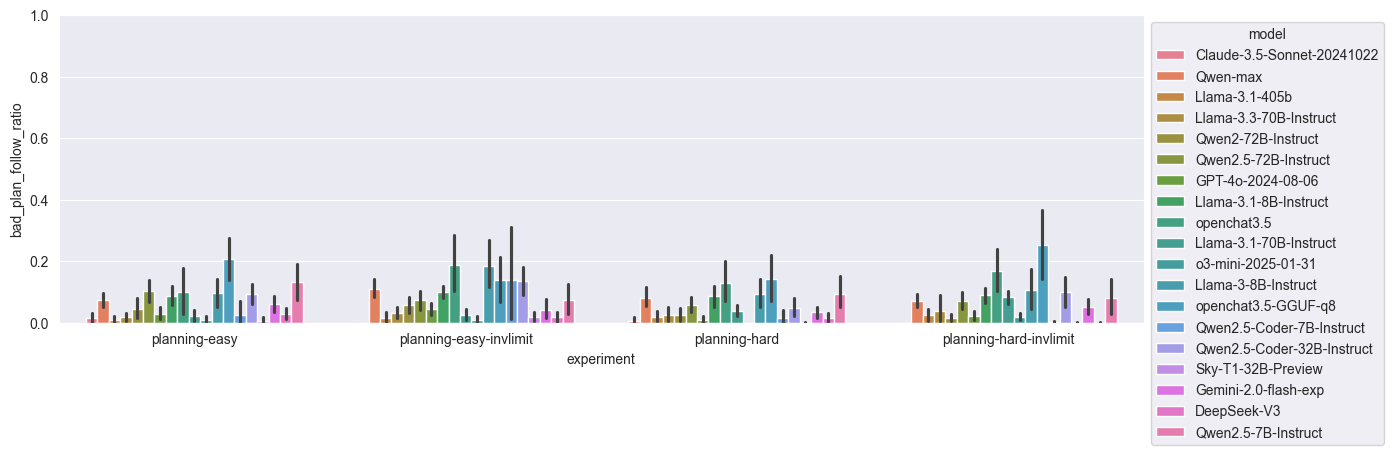

In [53]:
metric_bar_plot(plan_df, "bad_plan_follow_ratio")

C:\Users\JJ\AppData\Local\Temp\ipykernel_20736\8844963.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  metric_df = source_df[game_df.metric == metric].sort_values('experiment')


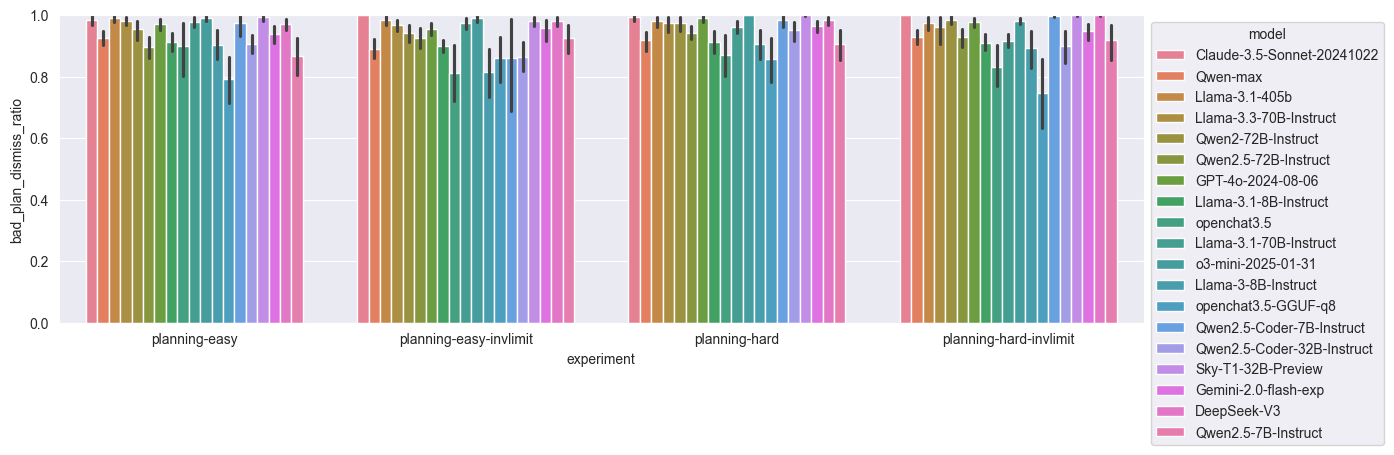

In [54]:
metric_bar_plot(plan_df, "bad_plan_dismiss_ratio")

C:\Users\JJ\AppData\Local\Temp\ipykernel_20736\8844963.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  metric_df = source_df[game_df.metric == metric].sort_values('experiment')


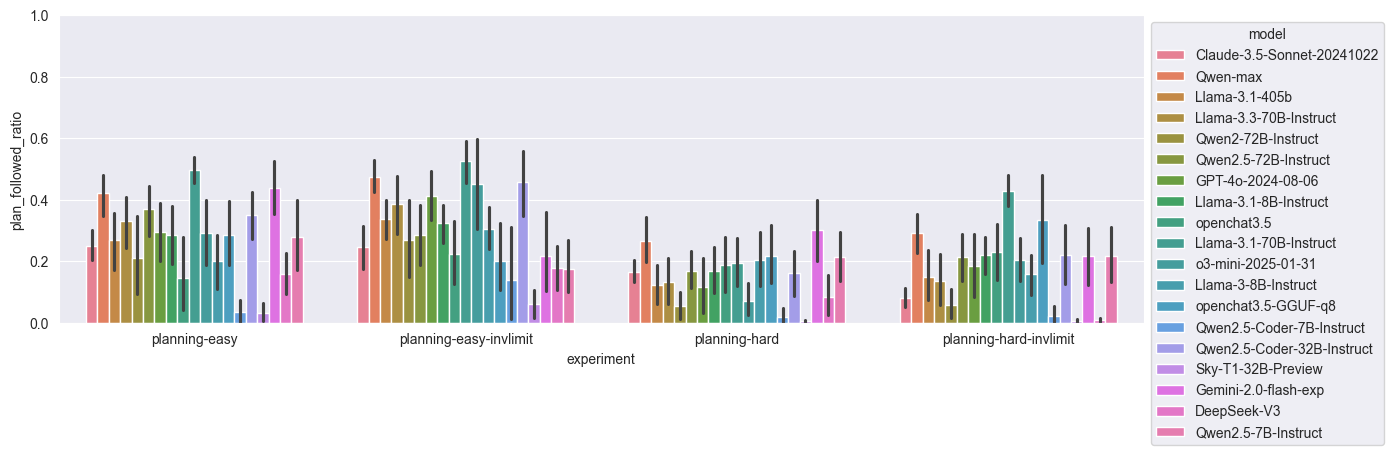

In [55]:
metric_bar_plot(plan_df, "plan_followed_ratio")

C:\Users\JJ\AppData\Local\Temp\ipykernel_20736\8844963.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  metric_df = source_df[game_df.metric == metric].sort_values('experiment')


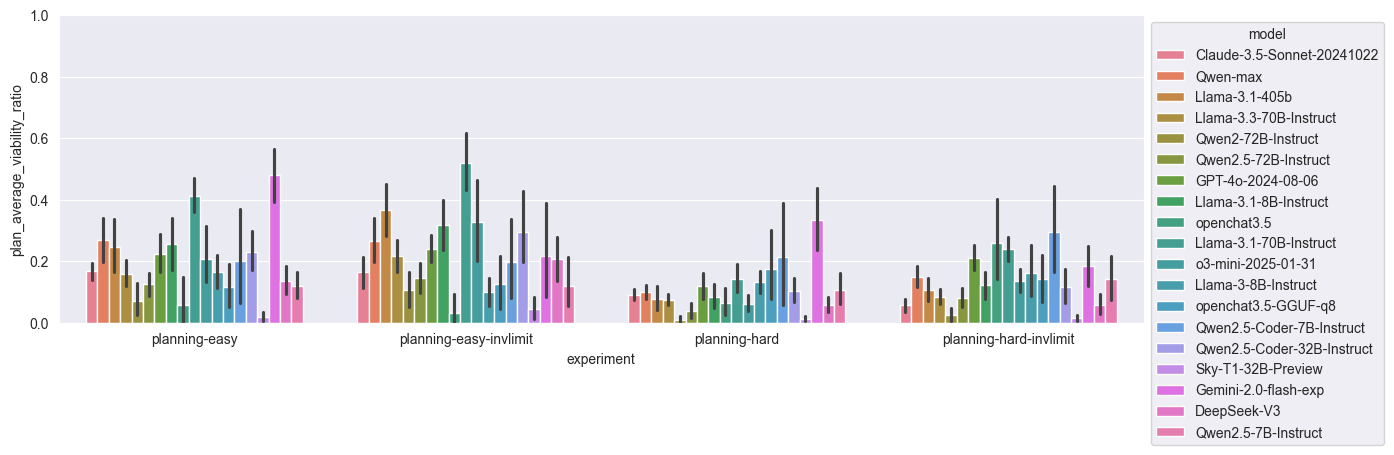

In [56]:
metric_bar_plot(plan_df, "plan_average_viability_ratio")

## Exploration

In [57]:
# get single episode for exploration line plot
model_id = "Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0"
variant = "0_home_deliver_three_basic_easy"
episode = "episode_0"
with open(f"results/{model_id}/adventuregame/{variant}/{episode}/scores.json") as scores_file:
    scores = json.load(scores_file)
turn_scores = scores['turn scores']
turns_known_entities_ratio = [score_values['known_entities_ratio'] for score_values in turn_scores.values()]
turns_known_entities_ratio

[0.13793103448275862,
 0.13793103448275862,
 0.1724137931034483,
 0.27586206896551724,
 0.27586206896551724,
 0.4827586206896552,
 0.4827586206896552,
 0.4827586206896552,
 0.4827586206896552,
 0.4827586206896552,
 0.4827586206896552]

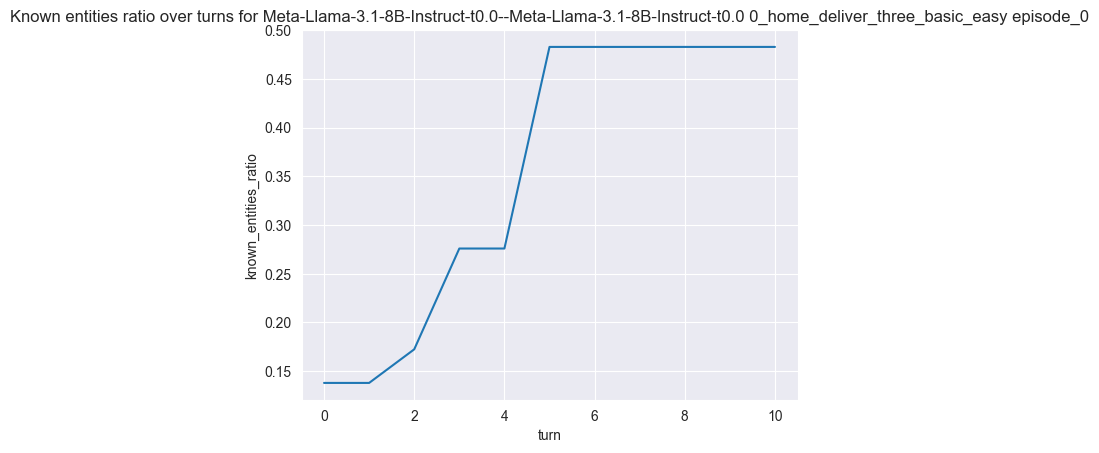

In [58]:
fig, ax = plt.subplots()
ax.plot(turns_known_entities_ratio)

ax.set(xlabel='turn', ylabel='known_entities_ratio',
       title=f'Known entities ratio over turns for {model_id} {variant} {episode}')
# ax.grid()

# fig.savefig("test.png")
plt.show()

In [59]:
# get single episode for exploration line plot
model_id = "Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0"
variant = "1_home_deliver_three_planning_easy"
episode = "episode_0"
with open(f"results/{model_id}/adventuregame/{variant}/{episode}/scores.json") as scores_file:
    scores = json.load(scores_file)
turn_scores = scores['turn scores']
turns_plan_command_success_ratio = [score_values['plan_command_success_ratio'] for score_values in turn_scores.values()]
turns_known_entities_ratio = [score_values['known_entities_ratio'] for score_values in turn_scores.values()]
turns_known_goal_entities_ratio = [score_values['known_goal_entities_ratio'] for score_values in turn_scores.values()]
turns_plan_command_success_ratio

[0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0]

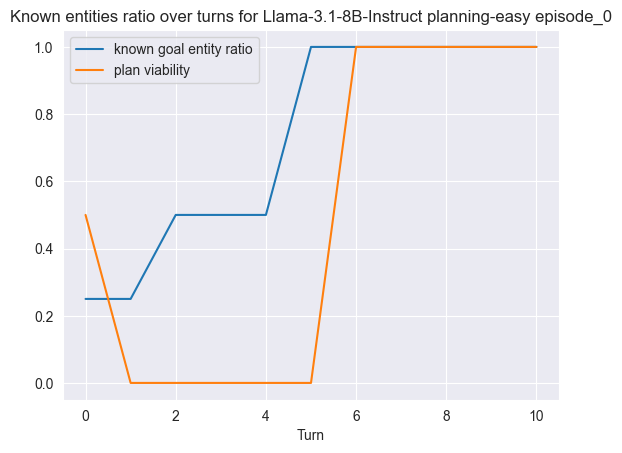

In [60]:
fig, ax = plt.subplots()

# ax.plot(turns_known_entities_ratio)
ax.plot(turns_known_goal_entities_ratio)
ax.plot(turns_plan_command_success_ratio)

ax.set(xlabel='Turn',
       title=f'Known entities ratio over turns for {model_name_dict[model_id]} {experiment_short_name_dict[variant]} {episode}')
# ax.grid()
ax.legend(['known goal entity ratio', 'plan viability'], loc='upper left')

# fig.savefig("test.png")
plt.show()

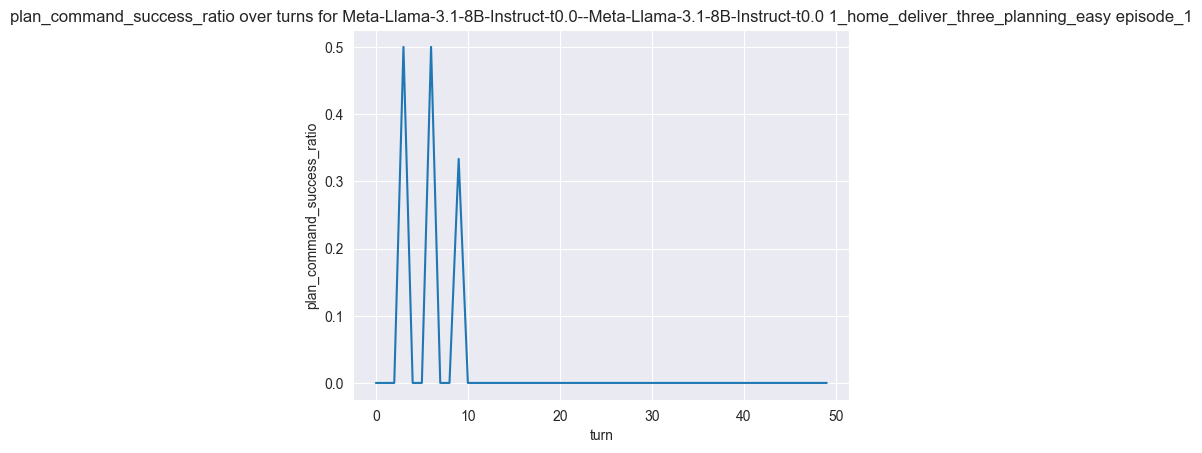

In [61]:
model_id = "Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0"
variant = "1_home_deliver_three_planning_easy"
episode = "episode_1"
with open(f"results/{model_id}/adventuregame/{variant}/{episode}/scores.json") as scores_file:
    scores = json.load(scores_file)
turn_scores = scores['turn scores']
turns_plan_command_success_ratio = [score_values['plan_command_success_ratio'] for score_values in turn_scores.values()]
# turns_plan_command_success_ratio

fig, ax = plt.subplots()

# ax.plot(turns_known_entities_ratio)
ax.plot(turns_plan_command_success_ratio)

ax.set(xlabel='turn', ylabel='plan_command_success_ratio',
       title=f'plan_command_success_ratio over turns for {model_id} {variant} {episode}')
# ax.grid()

# fig.savefig("test.png")
plt.show()

In [62]:
def get_score_progress_list(model_id: str, variant: str, episode: str, score: str):
    with open(f"results/{model_id}/adventuregame/{variant}/{episode}/scores.json") as scores_file:
        scores = json.load(scores_file)
    turn_scores = scores['turn scores']
    turns_score = [score_values[score] for score_values in turn_scores.values()]
    return turns_score

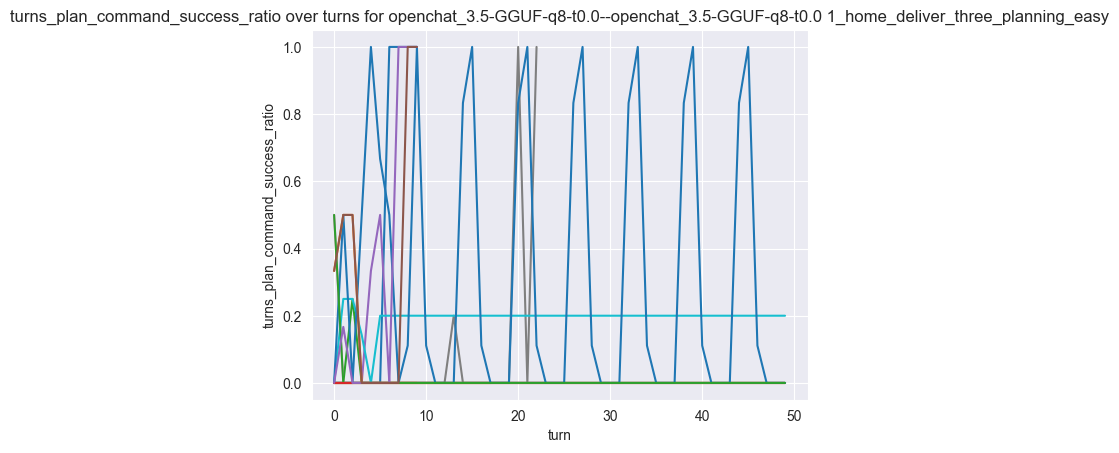

In [63]:
# model_id = "Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0"
model_id = "openchat_3.5-GGUF-q8-t0.0--openchat_3.5-GGUF-q8-t0.0"
variant = "1_home_deliver_three_planning_easy"
episodes = [f"episode_{number}" for number in range(0,16)]

fig, ax = plt.subplots()

for episode in episodes:
    turns_plan_command_success_ratio = get_score_progress_list(model_id, variant, episode, "plan_command_success_ratio")
    ax.plot(turns_plan_command_success_ratio)

ax.set(xlabel='turn', ylabel='turns_plan_command_success_ratio',
       title=f'turns_plan_command_success_ratio over turns for {model_id} {variant}')
# ax.grid()

# fig.savefig("test.png")
plt.show()

In [64]:
model_id = "Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0"
variant = "0_home_deliver_three_basic_easy"
episodes = [f"episode_{number}" for number in range(0,16)]

def get_exploration_progress_list(model_id: str, variant: str, episode: str, exploration_score: str):
    with open(f"results/{model_id}/adventuregame/{variant}/{episode}/scores.json") as scores_file:
        scores = json.load(scores_file)
    turn_scores = scores['turn scores']
    turns_exploration_score = [score_values[exploration_score] for score_values in turn_scores.values()]
    return turns_exploration_score

get_exploration_progress_list(model_id, variant, episodes[0], "known_entities_ratio")

[0.13793103448275862,
 0.13793103448275862,
 0.1724137931034483,
 0.27586206896551724,
 0.27586206896551724,
 0.4827586206896552,
 0.4827586206896552,
 0.4827586206896552,
 0.4827586206896552,
 0.4827586206896552,
 0.4827586206896552]

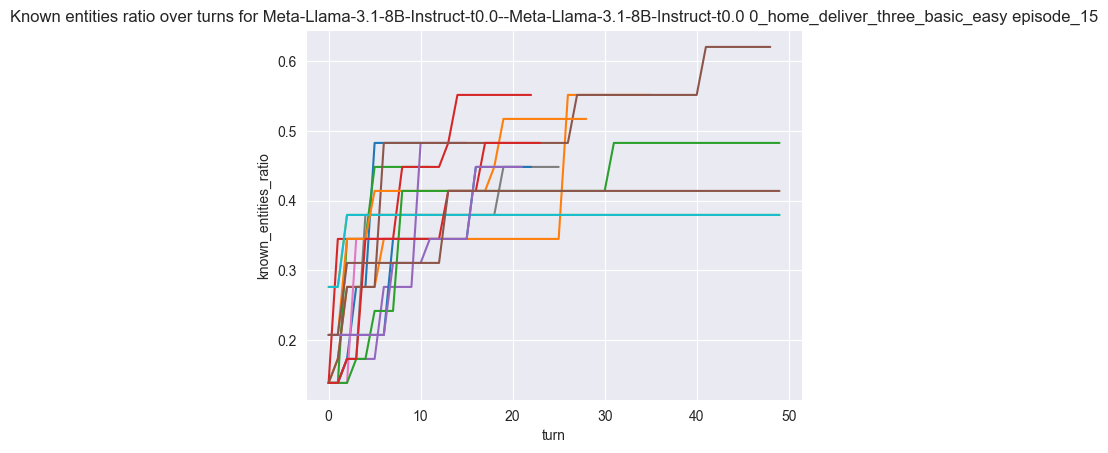

In [65]:
fig, ax = plt.subplots()

for episode in episodes:
    turns_known_entities_ratio = get_exploration_progress_list(model_id, variant, episode, "known_entities_ratio")
    ax.plot(turns_known_entities_ratio)

ax.set(xlabel='turn', ylabel='known_entities_ratio',
       title=f'Known entities ratio over turns for {model_id} {variant} {episode}')
# ax.grid()

# fig.savefig("test.png")
plt.show()

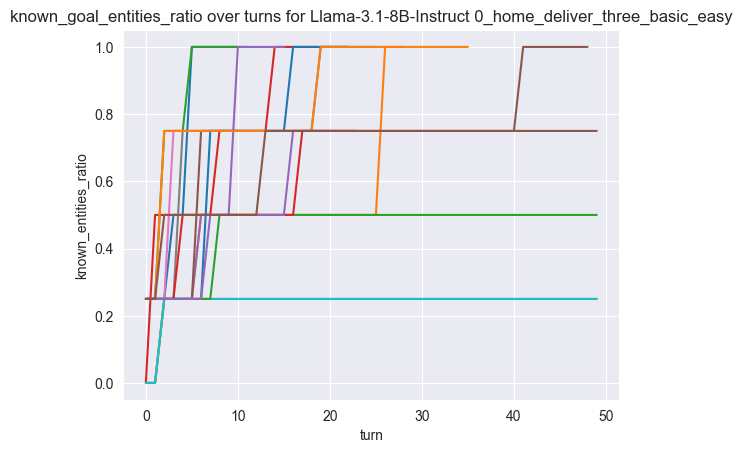

In [66]:
exploration_score = "known_goal_entities_ratio"

fig, ax = plt.subplots()

for episode in episodes:
    turns_known_entities_ratio = get_exploration_progress_list(model_id, variant, episode, exploration_score)
    ax.plot(turns_known_entities_ratio)

ax.set(xlabel='turn', ylabel='known_entities_ratio',
       title=f'{exploration_score} over turns for {model_name_dict[model_id]} {variant}')
# ax.grid()

# fig.savefig("test.png")
plt.show()

## Epistemic/Pragmatic

In [67]:
# get single episode for exploration line plot
model_id = "openchat_3.5-GGUF-q8-t0.0--openchat_3.5-GGUF-q8-t0.0"
# variant = "0_home_deliver_three_basic_easy"
variant = "2_home_deliver_three_basic_easy_invlimittwo"
# episode = "episode_0"
episode = "episode_2"
with open(f"results/{model_id}/adventuregame/{variant}/{episode}/scores.json") as scores_file:
    scores = json.load(scores_file)
turn_scores = scores['turn scores']
turns_epistemic = [score_values['epistemic_action'] for score_values in turn_scores.values()]
turns_pragmatic = [score_values['pragmatic_action'] for score_values in turn_scores.values()]
turns_epistemic_gain = [score_values['effective_epistemic_gain_amount'] for score_values in turn_scores.values()]
turns_goal_score = [score_values['goal_score'] for score_values in turn_scores.values()]
turns_resolution_fail = [score_values['action_resolution_fail'] for score_values in turn_scores.values()]
turns_parsing_fail = [score_values['action_parsing_fail'] for score_values in turn_scores.values()]

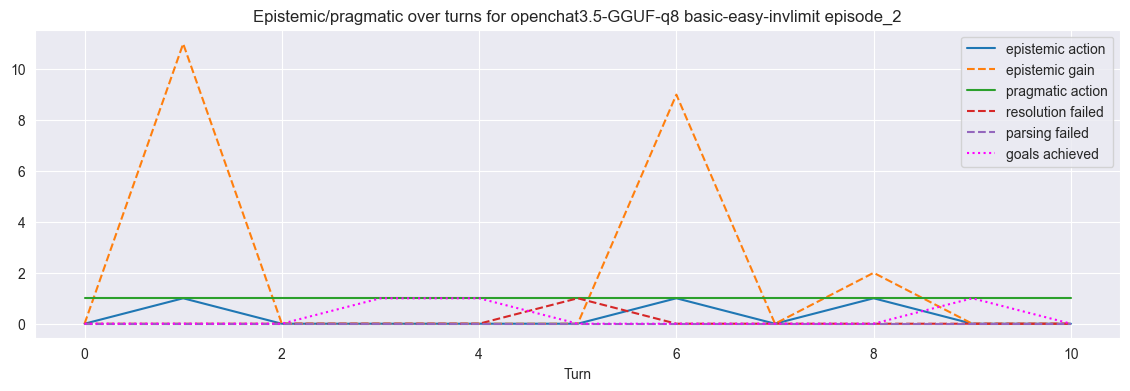

In [68]:
fig, ax = plt.subplots(figsize=(14, 4))

# ax.plot(turns_known_entities_ratio)
ax.plot(turns_epistemic)
ax.plot(turns_epistemic_gain, linestyle='dashed')
ax.plot(turns_pragmatic)
ax.plot(turns_resolution_fail, linestyle='dashed')
ax.plot(turns_parsing_fail, linestyle='dashed')
ax.plot(turns_goal_score, linestyle='dotted', color='magenta')

ax.set(xlabel='Turn',
       title=f'Epistemic/pragmatic over turns for {model_name_dict[model_id]} {experiment_short_name_dict[variant]} {episode}')
# ax.grid()
ax.legend(['epistemic action', 'epistemic gain', 'pragmatic action', 'resolution failed', 'parsing failed', 'goals achieved'], loc='upper right')

# fig.savefig("test.png")
plt.show()

### Average turns and epistemic/pragmatic actions

In [69]:
# get single episode for exploration line plot
model_id = "openchat_3.5-GGUF-q8-t0.0--openchat_3.5-GGUF-q8-t0.0"
# variant = "0_home_deliver_three_basic_easy"
variant = "2_home_deliver_three_basic_easy_invlimittwo"
# episode = "episode_0"
episode = "episode_2"
with open(f"results/{model_id}/adventuregame/{variant}/{episode}/scores.json") as scores_file:
    scores = json.load(scores_file)

In [70]:
def get_score_over_episodes(model_id, variant, score):
    all_episodes = list()
    if os.path.exists(f"results/{model_id}"):
        for ep_num in range(0,16):
            episode = f"episode_{ep_num}"
            # print(variant, episode)
            episode_score_list = list()
            with open(f"results/{model_id}/adventuregame/{variant}/{episode}/scores.json") as scores_file:
                scores = json.load(scores_file)
                # print("scores:", scores)
                ep_turn_scores = scores['turn scores']
                for turn_number, turn_dict in ep_turn_scores.items():
                    # print("turn number:", turn_number)
                    # in some cases the score might be missing on the last turn:
                    if score in turn_dict:
                        episode_score_list.append(turn_dict[score])
                all_episodes.append(episode_score_list)
        return all_episodes
    else:
        return []


In [71]:
epistemic_action_counts = get_score_over_episodes(model_id, variant, "epistemic_action")

In [72]:
numbers_of_turns = [len(episode_turns) for episode_turns in epistemic_action_counts]
numbers_of_turns

[6, 50, 11, 50, 6, 17, 15, 50, 22, 50, 10, 20, 50, 50, 15, 20]

In [73]:
numbers_of_epistemic_actions = [sum(episode_turns) for episode_turns in epistemic_action_counts]
numbers_of_epistemic_actions

[1, 14, 3, 13, 1, 8, 6, 30, 4, 21, 3, 7, 29, 12, 6, 7]

In [74]:
average_number_of_turns = np.average(numbers_of_turns)
average_number_of_turns

np.float64(27.625)

In [75]:
average_number_of_epistemic_actions = np.average(numbers_of_epistemic_actions)
average_number_of_epistemic_actions

np.float64(10.3125)

In [76]:
def get_average_score_over_experiments(model_id, score):
    variant_turns_average = list()
    variant_score_averages = list()
    for variant in experiment_short_name_dict.keys():
        variant_scores = get_score_over_episodes(model_id, variant, score)
        numbers_of_turns = [len(episode_turns) for episode_turns in variant_scores]
        numbers_of_scores = [sum(episode_turns) for episode_turns in variant_scores]
        average_number_of_turns = np.average(numbers_of_turns)
        variant_turns_average.append(average_number_of_turns)
        average_number_of_scores = np.average(numbers_of_scores)
        variant_score_averages.append(average_number_of_scores)
    return variant_turns_average, variant_score_averages


In [77]:
get_average_score_over_experiments(model_id, "epistemic_action")

([np.float64(30.875),
  np.float64(31.875),
  np.float64(27.625),
  np.float64(36.75),
  np.float64(38.25),
  np.float64(34.3125),
  np.float64(40.3125),
  np.float64(39.125)],
 [np.float64(10.625),
  np.float64(12.9375),
  np.float64(10.3125),
  np.float64(14.75),
  np.float64(20.5625),
  np.float64(20.25),
  np.float64(19.6875),
  np.float64(17.8125)])

In [78]:
get_average_score_over_experiments("Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0", "epistemic_action")

([np.float64(15.125),
  np.float64(16.125),
  np.float64(18.3125),
  np.float64(17.3125),
  np.float64(29.125),
  np.float64(31.25),
  np.float64(32.0625),
  np.float64(29.8125)],
 [np.float64(8.0),
  np.float64(8.5625),
  np.float64(9.625),
  np.float64(8.25),
  np.float64(19.625),
  np.float64(22.1875),
  np.float64(20.8125),
  np.float64(19.3125)])

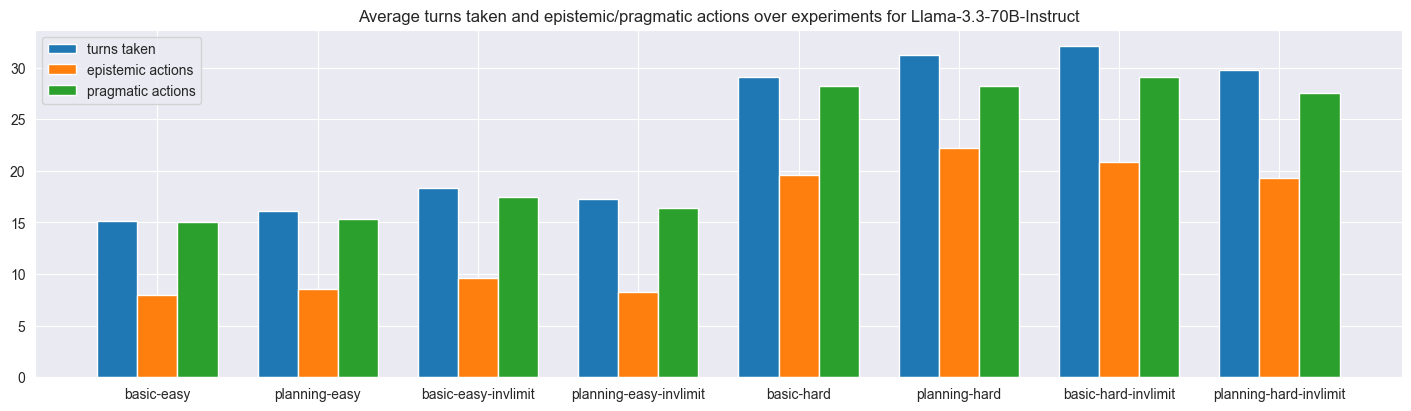

In [79]:
model_id = "Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0"
avg_epistemic_scores_tuple = get_average_score_over_experiments(model_id, "epistemic_action")
avg_turns = avg_epistemic_scores_tuple[0]
avg_epistemic_actions = avg_epistemic_scores_tuple[1]
avg_pragmatic_scores_tuple = get_average_score_over_experiments(model_id, "pragmatic_action")
avg_pragmatic_actions = avg_pragmatic_scores_tuple[1]

# variants_short = [experiment_short_name_dict[variant_long] for variant_long in variants]
variants_short = experiment_short_name_dict.values()

fig, ax = plt.subplots(figsize=(14, 4), layout='constrained')

barWidth = 0.25
br1 = np.arange(len(avg_turns))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

ax.bar(br1, avg_turns, width=barWidth, label="turns taken")
ax.bar(br2, avg_epistemic_actions, width=barWidth, label="epistemic actions")
ax.bar(br3, avg_pragmatic_actions, width=barWidth, label="pragmatic actions")


# ax.bar(variants_short, avg_turns, label="turns")
# ax.bar(variants_short, avg_epistemic_actions, label="epistemic actions")

# plt.bar(variants_short, avg_turns, width=0.25)
# plt.bar(variants_short, avg_epistemic_actions, width=0.25)


ax.set(title=f'Average turns taken and epistemic/pragmatic actions over experiments for {model_name_dict[model_id]}')

plt.xticks([r + barWidth for r in range(len(avg_turns))], variants_short)

# ax.grid()

plt.legend()

# fig.savefig("test.png")
plt.show()

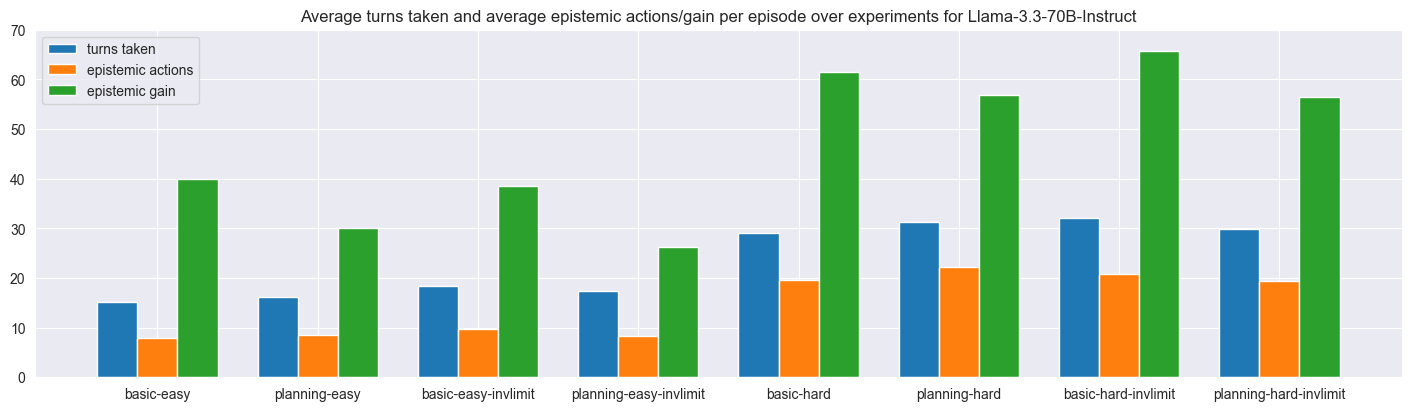

In [80]:
model_id = "Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0"
avg_epistemic_scores_tuple = get_average_score_over_experiments(model_id, "effective_epistemic_gain_amount")
avg_turns = avg_epistemic_scores_tuple[0]
avg_epistemic_gain = avg_epistemic_scores_tuple[1]
avg_epistemic_scores_tuple = get_average_score_over_experiments(model_id, "epistemic_action")
avg_epistemic_actions = avg_epistemic_scores_tuple[1]

# avg_pragmatic_scores_tuple = get_average_score_over_experiments(model_id, "pragmatic_action")
# avg_pragmatic_actions = avg_pragmatic_scores_tuple[1]

# variants_short = [experiment_short_name_dict[variant_long] for variant_long in variants]
variants_short = experiment_short_name_dict.values()

fig, ax = plt.subplots(figsize=(14, 4), layout='constrained')

barWidth = 0.25
br1 = np.arange(len(avg_turns))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

ax.bar(br1, avg_turns, width=barWidth, label="turns taken")
ax.bar(br2, avg_epistemic_actions, width=barWidth, label="epistemic actions")
ax.bar(br3, avg_epistemic_gain, width=barWidth, label="epistemic gain")

# ax.bar(variants_short, avg_turns, label="turns")
# ax.bar(variants_short, avg_epistemic_actions, label="epistemic actions")

# plt.bar(variants_short, avg_turns, width=0.25)
# plt.bar(variants_short, avg_epistemic_actions, width=0.25)


ax.set(title=f'Average turns taken and average epistemic actions/gain per episode over experiments for {model_name_dict[model_id]}')

plt.xticks([r + barWidth for r in range(len(avg_turns))], variants_short)

# ax.grid()

plt.ylim(0, 70)

plt.legend()

# fig.savefig("test.png")
plt.show()

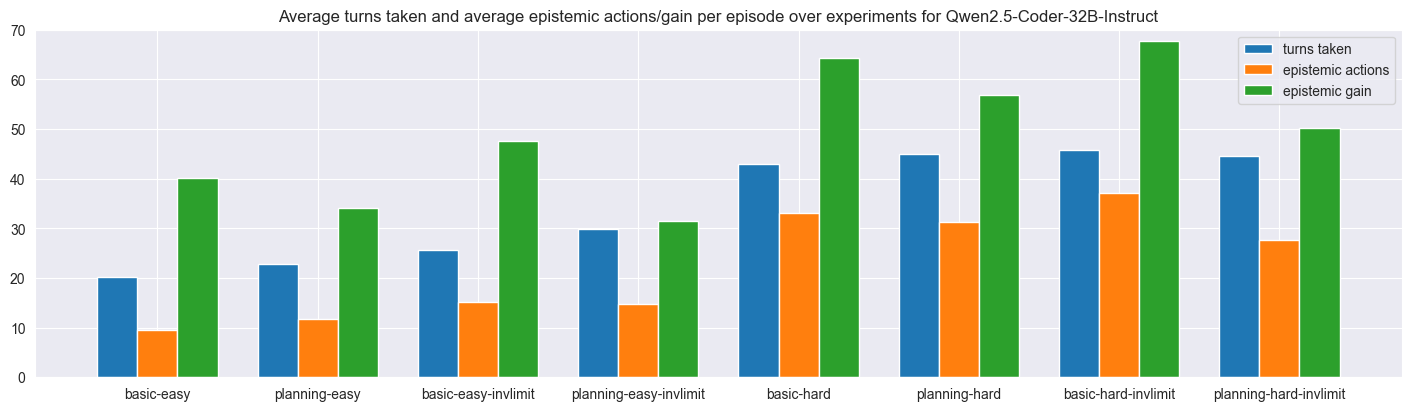

In [81]:
model_id = "Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0"
avg_epistemic_scores_tuple = get_average_score_over_experiments(model_id, "effective_epistemic_gain_amount")
avg_turns = avg_epistemic_scores_tuple[0]
avg_epistemic_gain = avg_epistemic_scores_tuple[1]
avg_epistemic_scores_tuple = get_average_score_over_experiments(model_id, "epistemic_action")
avg_epistemic_actions = avg_epistemic_scores_tuple[1]

# avg_pragmatic_scores_tuple = get_average_score_over_experiments(model_id, "pragmatic_action")
# avg_pragmatic_actions = avg_pragmatic_scores_tuple[1]

# variants_short = [experiment_short_name_dict[variant_long] for variant_long in variants]
variants_short = experiment_short_name_dict.values()

fig, ax = plt.subplots(figsize=(14, 4), layout='constrained')

barWidth = 0.25
br1 = np.arange(len(avg_turns))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

ax.bar(br1, avg_turns, width=barWidth, label="turns taken")
ax.bar(br2, avg_epistemic_actions, width=barWidth, label="epistemic actions")
ax.bar(br3, avg_epistemic_gain, width=barWidth, label="epistemic gain")

# ax.bar(variants_short, avg_turns, label="turns")
# ax.bar(variants_short, avg_epistemic_actions, label="epistemic actions")

# plt.bar(variants_short, avg_turns, width=0.25)
# plt.bar(variants_short, avg_epistemic_actions, width=0.25)


ax.set(title=f'Average turns taken and average epistemic actions/gain per episode over experiments for {model_name_dict[model_id]}')

plt.xticks([r + barWidth for r in range(len(avg_turns))], variants_short)

plt.ylim(0, 70)

# ax.grid()

plt.legend()

# fig.savefig("test.png")
plt.show()

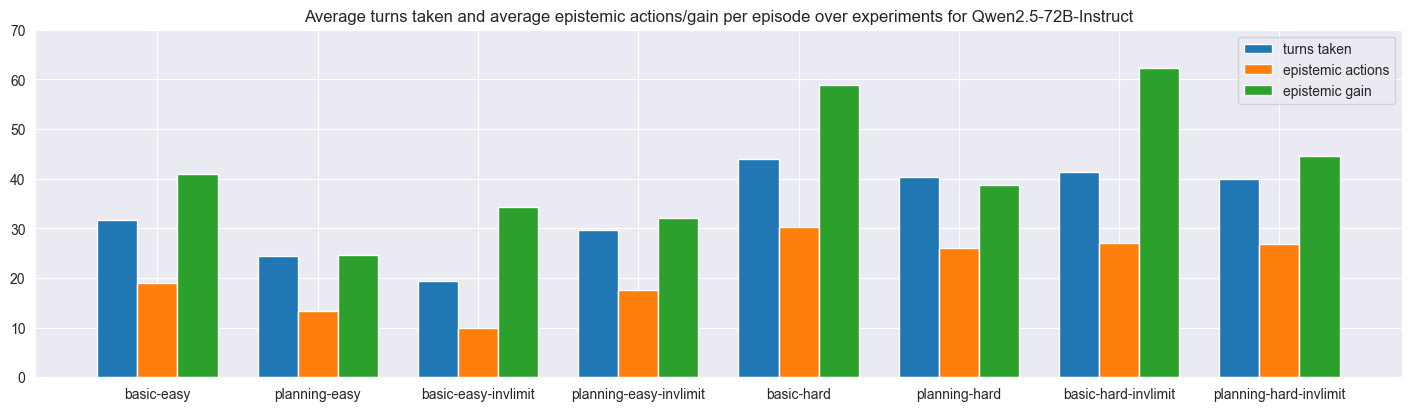

In [82]:
model_id = "Qwen2.5-72B-Instruct-t0.0--Qwen2.5-72B-Instruct-t0.0"
avg_epistemic_scores_tuple = get_average_score_over_experiments(model_id, "effective_epistemic_gain_amount")
avg_turns = avg_epistemic_scores_tuple[0]
# print("avg_turns", avg_turns)
avg_epistemic_gain = avg_epistemic_scores_tuple[1]
avg_epistemic_scores_tuple = get_average_score_over_experiments(model_id, "epistemic_action")
avg_epistemic_actions = avg_epistemic_scores_tuple[1]

# avg_pragmatic_scores_tuple = get_average_score_over_experiments(model_id, "pragmatic_action")
# avg_pragmatic_actions = avg_pragmatic_scores_tuple[1]

# variants_short = [experiment_short_name_dict[variant_long] for variant_long in variants]
variants_short = experiment_short_name_dict.values()

fig, ax = plt.subplots(figsize=(14, 4), layout='constrained')

barWidth = 0.25
br1 = np.arange(len(avg_turns))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

ax.bar(br1, avg_turns, width=barWidth, label="turns taken")
ax.bar(br2, avg_epistemic_actions, width=barWidth, label="epistemic actions")
ax.bar(br3, avg_epistemic_gain, width=barWidth, label="epistemic gain")

# ax.bar(variants_short, avg_turns, label="turns")
# ax.bar(variants_short, avg_epistemic_actions, label="epistemic actions")

# plt.bar(variants_short, avg_turns, width=0.25)
# plt.bar(variants_short, avg_epistemic_actions, width=0.25)


ax.set(title=f'Average turns taken and average epistemic actions/gain per episode over experiments for {model_name_dict[model_id]}')

plt.xticks([r + barWidth for r in range(len(avg_turns))], variants_short)

plt.ylim(0, 70)

# ax.grid()

plt.legend()

# fig.savefig("test.png")
plt.show()

ValueError: The number of FixedLocator locations (1), usually from a call to set_ticks, does not match the number of labels (20).

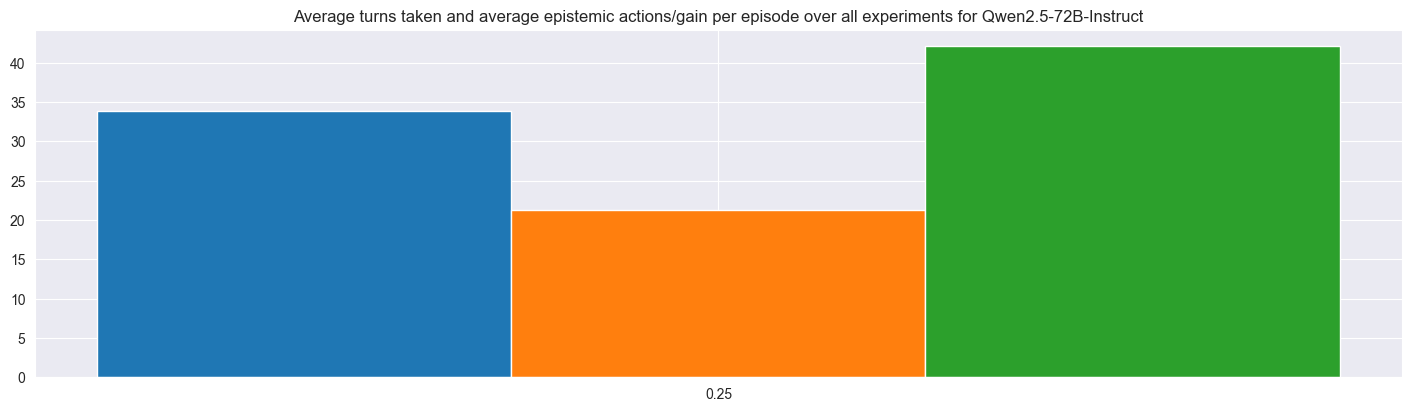

In [83]:
model_id = "Qwen2.5-72B-Instruct-t0.0--Qwen2.5-72B-Instruct-t0.0"
avg_epistemic_scores_tuple = get_average_score_over_experiments(model_id, "effective_epistemic_gain_amount")
avg_turns = avg_epistemic_scores_tuple[0]
avg_turns_overall = np.average(avg_epistemic_scores_tuple[0])
avg_epistemic_gain = avg_epistemic_scores_tuple[1]
avg_epistemic_gain_overall = np.average(avg_epistemic_scores_tuple[1])
avg_epistemic_scores_tuple = get_average_score_over_experiments(model_id, "epistemic_action")
avg_epistemic_actions = avg_epistemic_scores_tuple[1]
avg_epistemic_actions_overall = np.average(avg_epistemic_scores_tuple[1])

# avg_pragmatic_scores_tuple = get_average_score_over_experiments(model_id, "pragmatic_action")
# avg_pragmatic_actions = avg_pragmatic_scores_tuple[1]

# variants_short = [experiment_short_name_dict[variant_long] for variant_long in variants]
variants_short = experiment_short_name_dict.values()

fig, ax = plt.subplots(figsize=(14, 4), layout='constrained')

barWidth = 0.25
# br1 = np.arange(len(avg_turns))
br1 = np.arange(1)
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

ax.bar(br1, avg_turns_overall, width=barWidth, label="turns taken")
ax.bar(br2, avg_epistemic_actions_overall, width=barWidth, label="epistemic actions")
ax.bar(br3, avg_epistemic_gain_overall, width=barWidth, label="epistemic gain")

# ax.bar(variants_short, avg_turns, label="turns")
# ax.bar(variants_short, avg_epistemic_actions, label="epistemic actions")

# plt.bar(variants_short, avg_turns, width=0.25)
# plt.bar(variants_short, avg_epistemic_actions, width=0.25)


ax.set(title=f'Average turns taken and average epistemic actions/gain per episode over all experiments for {model_name_dict[model_id]}')

# plt.xticks([r + barWidth for r in range(len(avg_turns))], model_name_dict[model_id])
plt.xticks([r + barWidth for r in range(1)], model_name_dict[model_id])

plt.ylim(0, 70)

# ax.grid()

plt.legend()

# fig.savefig("test.png")
plt.show()

In [154]:
# get averages for all models
def get_average_epistemic_all(model_names = None):
    avg_turns_list = list()
    avg_epistemic_gain_list = list()
    avg_epistemic_actions_list = list()
    avg_plan_viability_list = list()

    if not model_names:
        model_names = model_name_dict.keys()

    for model_id in model_names:
        print(model_id)
        avg_epistemic_scores_tuple = get_average_score_over_experiments(model_id, "effective_epistemic_gain_amount")
        avg_turns = avg_epistemic_scores_tuple[0]
        # print("avg_turns", avg_turns)
        avg_turns_overall = np.average(avg_epistemic_scores_tuple[0])
        # print("avg_turns_overall", avg_turns_overall)
        if not np.isnan(avg_turns_overall):
            avg_turns_list.append(avg_turns_overall)
        avg_epistemic_gain = avg_epistemic_scores_tuple[1]
        avg_epistemic_gain_overall = np.average(avg_epistemic_scores_tuple[1])
        if not np.isnan(avg_epistemic_gain_overall):
            avg_epistemic_gain_list.append(avg_epistemic_gain_overall)
        avg_epistemic_scores_tuple = get_average_score_over_experiments(model_id, "epistemic_action")
        avg_epistemic_actions = avg_epistemic_scores_tuple[1]
        avg_epistemic_actions_overall = np.average(avg_epistemic_scores_tuple[1])
        if not np.isnan(avg_epistemic_actions_overall):
            avg_epistemic_actions_list.append(avg_epistemic_actions_overall)
        avg_plan_viability_tuple = get_average_score_over_experiments(model_id, "plan_command_success_ratio")
        avg_plan_viability = avg_plan_viability_tuple[1]
        avg_plan_viability_overall = np.average(avg_plan_viability_tuple[1])
        if not np.isnan(avg_plan_viability_overall):
            avg_plan_viability_list.append(avg_plan_viability_overall)
    return avg_turns_list, avg_epistemic_gain_list, avg_epistemic_actions_list, avg_plan_viability_list

In [155]:
avg_turns_list, avg_epistemic_gain_list, avg_epistemic_actions_list, avg_plan_viability_list = get_average_epistemic_all(top_models)
print(avg_turns_list)
print(avg_epistemic_gain_list)
print(avg_epistemic_actions_list)
print(avg_plan_viability_list)

o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0
claude-3-5-sonnet-20241022-t0.0--claude-3-5-sonnet-20241022-t0.0
gpt-4o-2024-08-06-t0.0--gpt-4o-2024-08-06-t0.0
Meta-Llama-3.1-70B-Instruct-t0.0--Meta-Llama-3.1-70B-Instruct-t0.0
Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0
[np.float64(23.0078125), np.float64(19.6484375), np.float64(24.171875), np.float64(23.2421875), np.float64(34.578125)]
[np.float64(45.0), np.float64(45.15625), np.float64(43.03125), np.float64(45.6953125), np.float64(49.0546875)]
[np.float64(13.3984375), np.float64(11.7890625), np.float64(14.8359375), np.float64(14.1015625), np.float64(22.5703125)]
[np.float64(1.707009548611111), np.float64(1.0041666666666667), np.float64(2.0682576321248196), np.float64(3.175799851190476), np.float64(2.5819847470238093)]


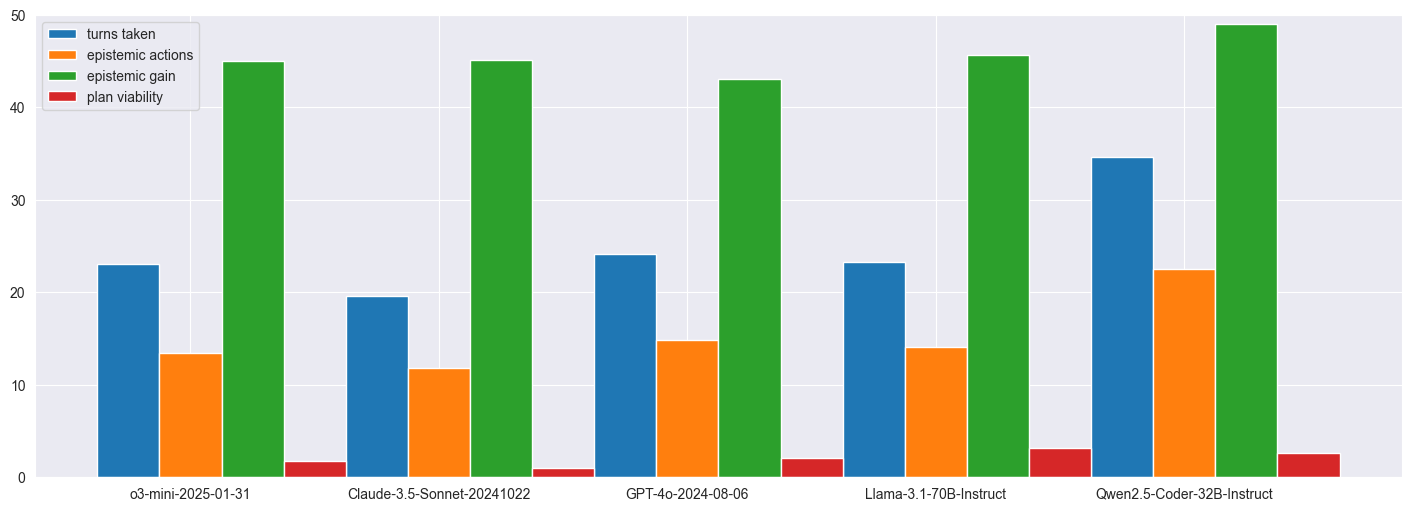

In [156]:
# print("avg_turns_list", avg_turns_list)

fig, ax = plt.subplots(figsize=(14, 5), layout='constrained')

barWidth = 0.25
br1 = np.arange(len(avg_turns_list))
# br1 = np.arange(1)
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]

# ax.bar(br1, avg_plan_viability_list, width=barWidth, label="plan viability")


ax.bar(br1, avg_turns_list, width=barWidth, label="turns taken")
ax.bar(br2, avg_epistemic_actions_list, width=barWidth, label="epistemic actions")
ax.bar(br3, avg_epistemic_gain_list, width=barWidth, label="epistemic gain")
ax.bar(br4, avg_plan_viability_list, width=barWidth, label="plan viability")

# ax.bar(variants_short, avg_turns, label="turns")
# ax.bar(variants_short, avg_epistemic_actions, label="epistemic actions")

# plt.bar(variants_short, avg_turns, width=0.25)
# plt.bar(variants_short, avg_epistemic_actions, width=0.25)

# TODO: error bars

# ax.set(title=f'Averages of turns taken, epistemic actions/gain and plan viability per episode over all experiments for all models')

# plt.xticks([r + barWidth for r in range(len(avg_turns))], model_name_dict[model_id])
# plt.xticks([r + barWidth for r in range(len(avg_turns_list))], model_name_dict.values(), rotation=45)
# plt.xticks([r + barWidth for r in range(len(avg_turns_list))], [model_name_dict[model_full] for model_full in top_models], rotation=45)
plt.xticks([r + barWidth for r in range(len(avg_turns_list))], [model_name_dict[model_full] for model_full in top_models])

plt.ylim(0, 50)

# ax.grid()

plt.legend()

# fig.savefig("test.png")
plt.show()

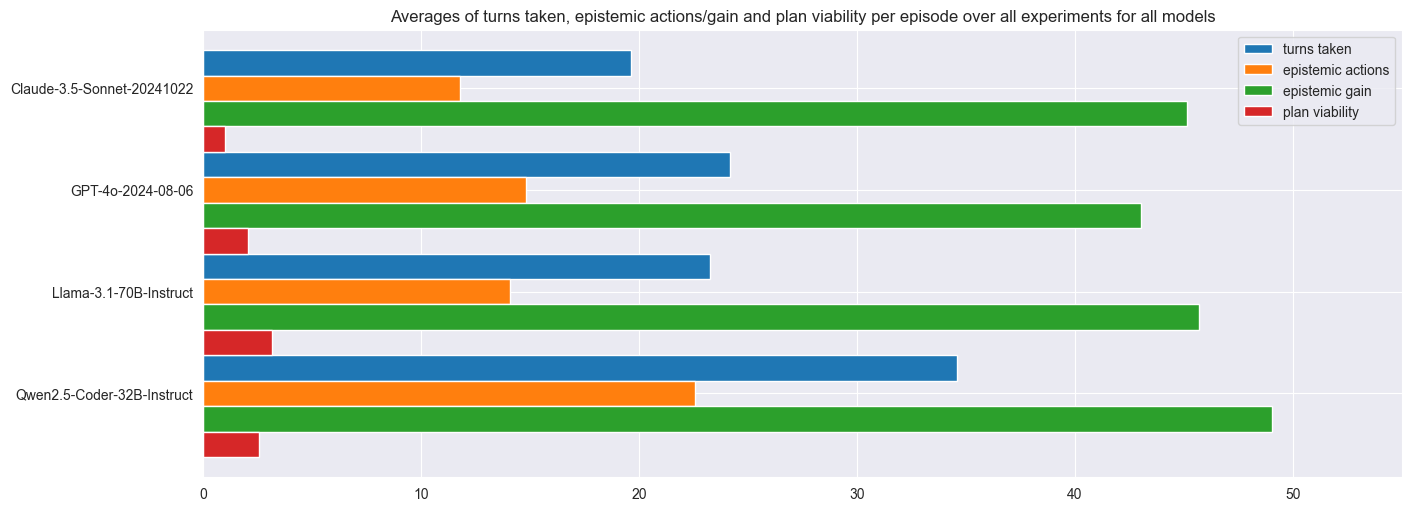

In [194]:
fig, ax = plt.subplots(figsize=(14, 5), layout='constrained')

barWidth = 0.25
br1 = np.arange(len(avg_turns_list))
# br1 = np.arange(1)
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]

# ax.bar(br1, avg_plan_viability_list, width=barWidth, label="plan viability")


ax.barh(br1, avg_turns_list, height=barWidth, label="turns taken")

ax.barh(br2, avg_epistemic_actions_list, height=barWidth, label="epistemic actions")
ax.barh(br3, avg_epistemic_gain_list, height=barWidth, label="epistemic gain")
ax.barh(br4, avg_plan_viability_list, height=barWidth, label="plan viability")


# ax.bar(variants_short, avg_turns, label="turns")
# ax.bar(variants_short, avg_epistemic_actions, label="epistemic actions")

# plt.bar(variants_short, avg_turns, width=0.25)
# plt.bar(variants_short, avg_epistemic_actions, width=0.25)

ax.invert_yaxis()

ax.set(title=f'Averages of turns taken, epistemic actions/gain and plan viability per episode over all experiments for all models')

# plt.xticks([r + barWidth for r in range(len(avg_turns))], model_name_dict[model_id])
# plt.xticks([r + barWidth for r in range(len(avg_turns_list))], model_name_dict.values(), rotation=45)
# plt.yticks([r + barWidth for r in range(len(avg_turns_list))], model_name_dict.values())
plt.yticks([r + barWidth for r in range(len(avg_turns_list))], [model_name_dict[model_full] for model_full in top_models])

plt.xlim(0, 55)

# ax.grid()

plt.legend()

# fig.savefig("test.png")
plt.show()